In [1]:
!pip install numpy pandas scikit-learn matplotlib seaborn umap-learn
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/FML/data.csv")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score, f1_score, roc_curve, roc_auc_score,
                             classification_report)
from sklearn.calibration import calibration_curve

# Drop Identifiers
identifier_cols = [col for col in data.columns if data[col].nunique() == len(data)]
data = data.drop(columns=identifier_cols)

# Clean Term Column
if 'term' in data.columns:
    data['term'] = data['term'].astype(str).str.replace(' months', '').str.strip().astype(float)

# Clean Emp Length
if 'emp_length' in data.columns:
    data['emp_length'] = data['emp_length'].astype(str).str.extract(r'(\d+)').astype(float)

# Remove High Correlation
numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
corr_matrix = data[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]
data = data.drop(columns=to_drop_corr)

# Encode Categorical
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if "loan_status" in categorical_cols: categorical_cols.remove("loan_status")
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data[categorical_cols] = enc.fit_transform(data[categorical_cols])
if "loan_status" in data.columns: data = data.drop(columns=["loan_status"])

# Map Booleans
bool_like_cols = []
for col in data.columns:
    unique_vals = set(str(v).lower() for v in data[col].dropna().unique())
    if unique_vals.issubset({"true","false","t","f","yes","no","y","n"}):
        bool_like_cols.append(col)

for col in bool_like_cols:
    data[col] = data[col].astype(str).str.lower().map({
        "true":1,"t":1,"yes":1,"y":1, "false":0,"f":0,"no":0,"n":0
    }).astype(int)

# Scale Numeric Features
numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
if "default_binary" in numeric_cols: numeric_cols.remove("default_binary")
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Train Test Split
X = data.drop(columns=["default_binary"])
y = data["default_binary"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Symmetric Noise
def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    if isinstance(y_noisy, pd.Series):
        y_noisy.iloc[flip_indices] = 1 - y_noisy.iloc[flip_indices]
    else:
        y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

# Asymmetric Noise
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    if isinstance(y_noisy, pd.Series):
        y_noisy.iloc[flip_idx] = 1 - class_to_flip
    else:
        y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

# Missingness Injector
def inject_missingness(X, missing_rate, random_state=42):
    np.random.seed(random_state)
    X_noisy = X.copy()
    mask = np.random.rand(*X_noisy.shape) < missing_rate
    if isinstance(X_noisy, pd.DataFrame):
        X_noisy = X_noisy.mask(mask)
    else:
        X_noisy[mask] = np.nan
    return X_noisy

# Helper to Add Labels
def add_bar_labels(bars, ax, is_int=False):
    for bar in bars:
        height = bar.get_height()
        label = f'{int(height)}' if is_int else f'{height:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Evaluation Plotter
def evaluate_and_plot(model, X_test, y_test, title_suffix):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nRESULTS: {title_suffix}")
    print(f"Acc: {acc:.4f} | AUC: {auc:.4f} | F1: {f1:.4f}")

    fig = plt.figure(figsize=(18, 12))
    plt.suptitle(f'SVM (RBF): {title_suffix}', fontsize=16, fontweight='bold')

    # 1. Heatmap
    ax1 = plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=ax1)
    ax1.set_title('Confusion Matrix')

    # 2. Metrics Bar
    ax2 = plt.subplot(2, 3, 2)
    metrics = [acc, prec, rec, f1, auc]
    bars2 = ax2.bar(['Acc', 'Prec', 'Rec', 'F1', 'AUC'], metrics, color='#9467bd')
    ax2.set_ylim(0, 1.15)
    add_bar_labels(bars2, ax2)
    ax2.set_title('Metrics Overview')

    # 3. Class Imbalance Bar
    ax3 = plt.subplot(2, 3, 3)
    bars3 = ax3.bar(['Prec', 'Rec', 'F1'], [prec, rec, f1], color='#e377c2')
    ax3.set_ylim(0, 1.15)
    add_bar_labels(bars3, ax3)
    ax3.set_title('Class Imbalance Metrics')

    # 4. ROC Curve
    ax4 = plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax4.plot(fpr, tpr, label=f'AUC={auc:.3f}', color='purple')
    ax4.plot([0, 1], [0, 1], 'k--')
    ax4.legend()
    ax4.set_title('ROC Curve')

    # 5. Calibration Curve
    ax5 = plt.subplot(2, 3, 5)
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    ax5.plot(prob_pred, prob_true, marker='o', color='purple')
    ax5.plot([0, 1], [0, 1], 'k--')
    ax5.set_title('Calibration Curve')

    # 6. Confusion Details Bar
    ax6 = plt.subplot(2, 3, 6)
    tn, fp, fn, tp = cm.ravel()
    bars6 = ax6.bar(['TN', 'FP', 'FN', 'TP'], [tn, fp, fn, tp], color=['g', 'r', 'orange', 'b'])
    add_bar_labels(bars6, ax6, is_int=True)
    ax6.set_title('Confusion Details')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print(classification_report(y_test, y_pred))

# Baseline SVM
svc_baseline = SVC(probability=True, kernel='rbf', random_state=42)
svc_baseline.fit(X_train, y_train)
evaluate_and_plot(svc_baseline, X_test, y_test, "Baseline (No Noise)")

# Symmetric Loop
symmetric_rates = [0.10, 0.20, 0.33, 0.50]
for p in symmetric_rates:
    y_train_noisy = inject_symmetric_noise(y_train, noise_rate=p)
    svc_sym = SVC(probability=True, kernel='rbf', random_state=42)
    svc_sym.fit(X_train, y_train_noisy)
    evaluate_and_plot(svc_sym, X_test, y_test, f"Symmetric Noise {int(p*100)}%")

# Asymmetric Loop
asymmetric_rates = [0.10, 0.20, 0.33, 0.50]
class_to_flip = 0
for p in asymmetric_rates:
    y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)
    svc_asym = SVC(probability=True, kernel='rbf', random_state=42)
    svc_asym.fit(X_train, y_train_noisy)
    evaluate_and_plot(svc_asym, X_test, y_test, f"Asymmetric Noise {int(p*100)}%")

# Missing Loop
missing_rates = [0.10, 0.20, 0.33, 0.50]
for p in missing_rates:
    X_train_missing = inject_missingness(X_train, missing_rate=p)
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train_missing)
    X_test_imputed = imputer.transform(X_test)

    svc_missing = SVC(probability=True, kernel='rbf', random_state=42)
    svc_missing.fit(X_train_imputed, y_train)
    evaluate_and_plot(svc_missing, X_test_imputed, y_test, f"Missing Values {int(p*100)}%")


RESULTS: Baseline (No Noise)
Acc: 0.9588 | AUC: 0.9930 | F1: 0.9594


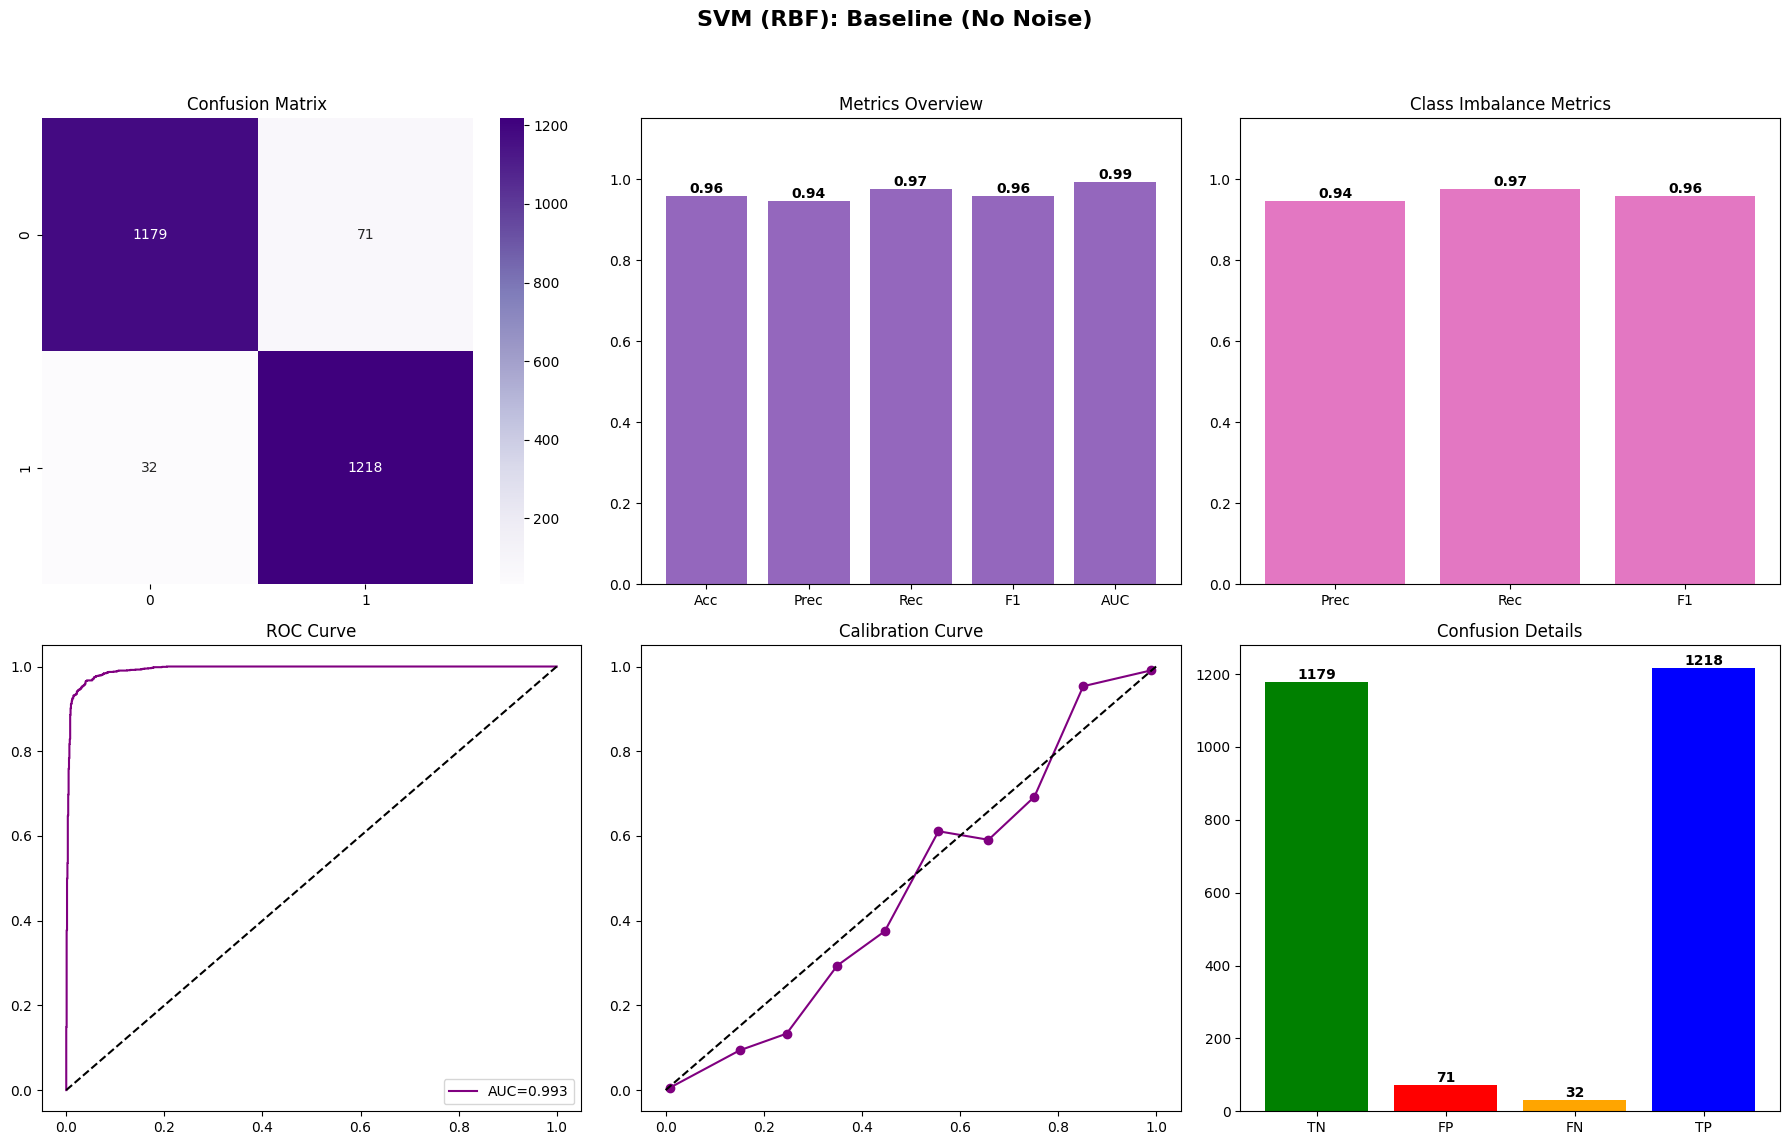

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1250
           1       0.94      0.97      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500


RESULTS: Symmetric Noise 10%
Acc: 0.9432 | AUC: 0.9887 | F1: 0.9441


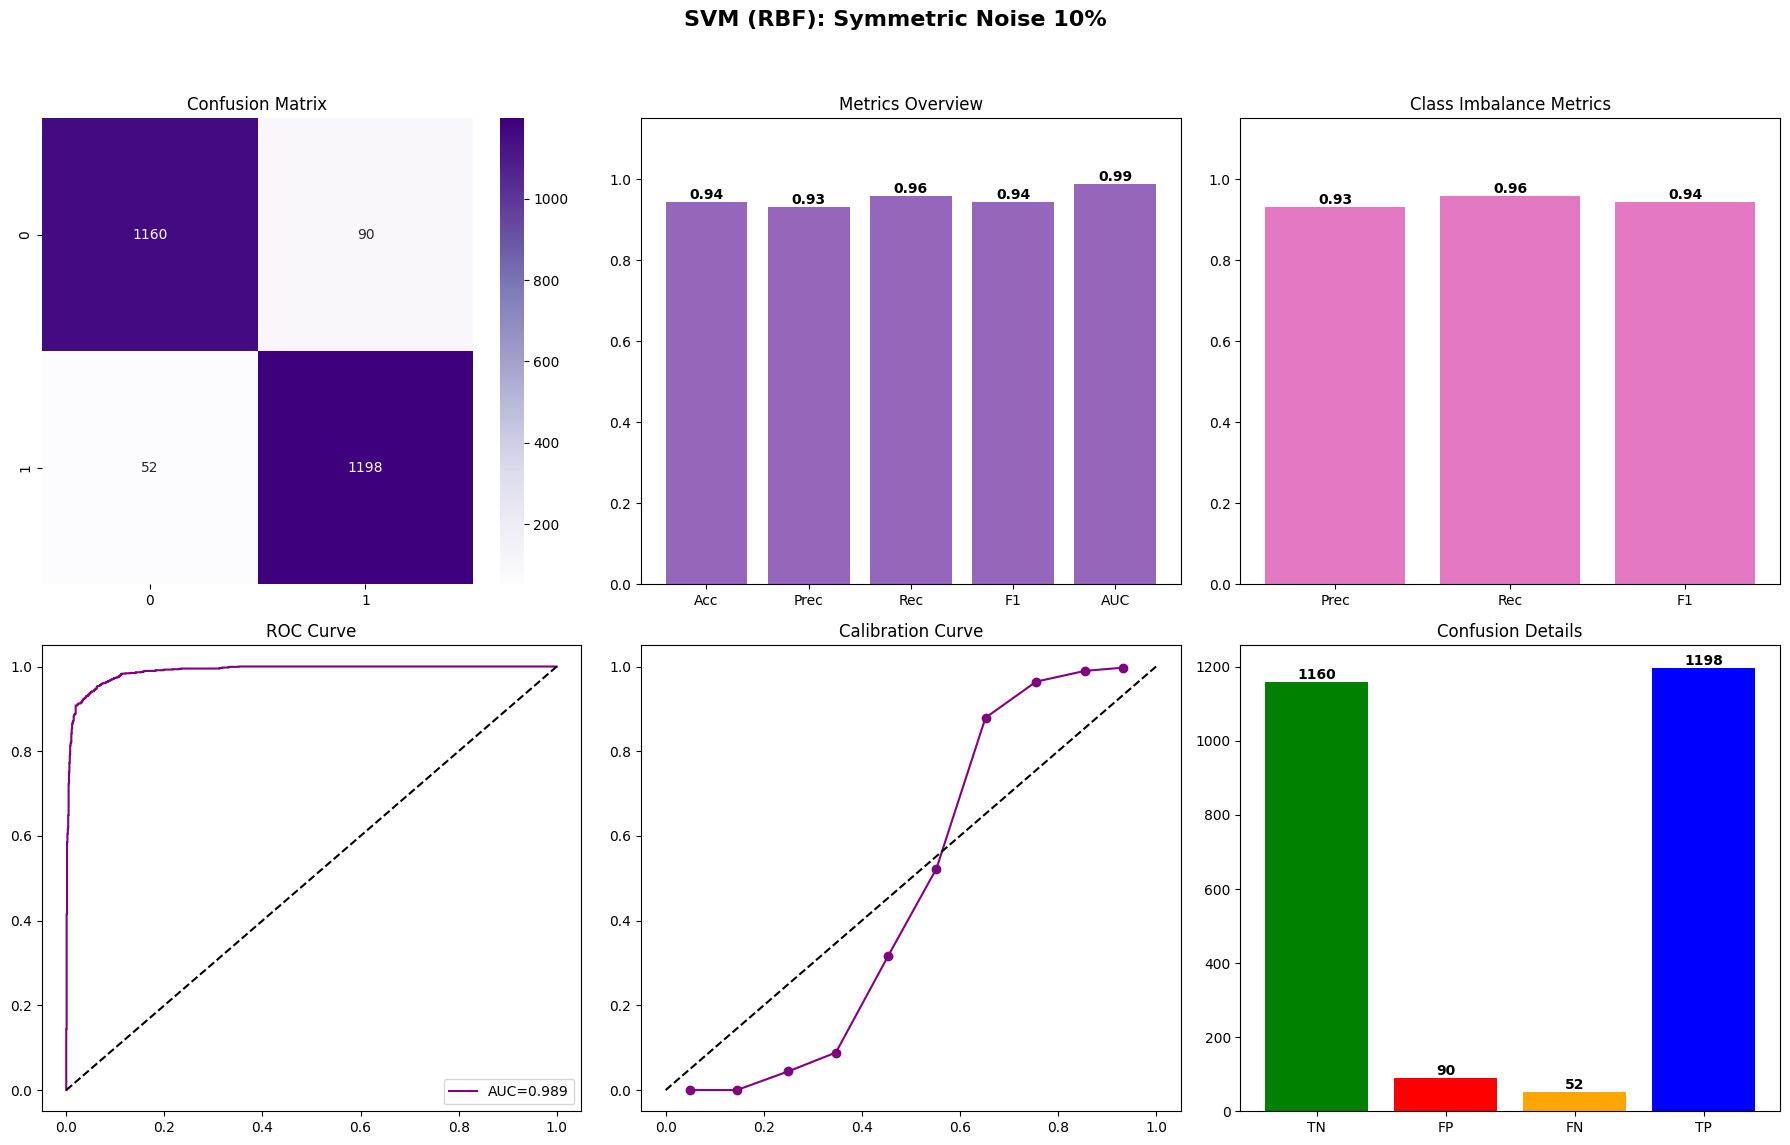

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1250
           1       0.93      0.96      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500


RESULTS: Symmetric Noise 20%
Acc: 0.9308 | AUC: 0.9840 | F1: 0.9318


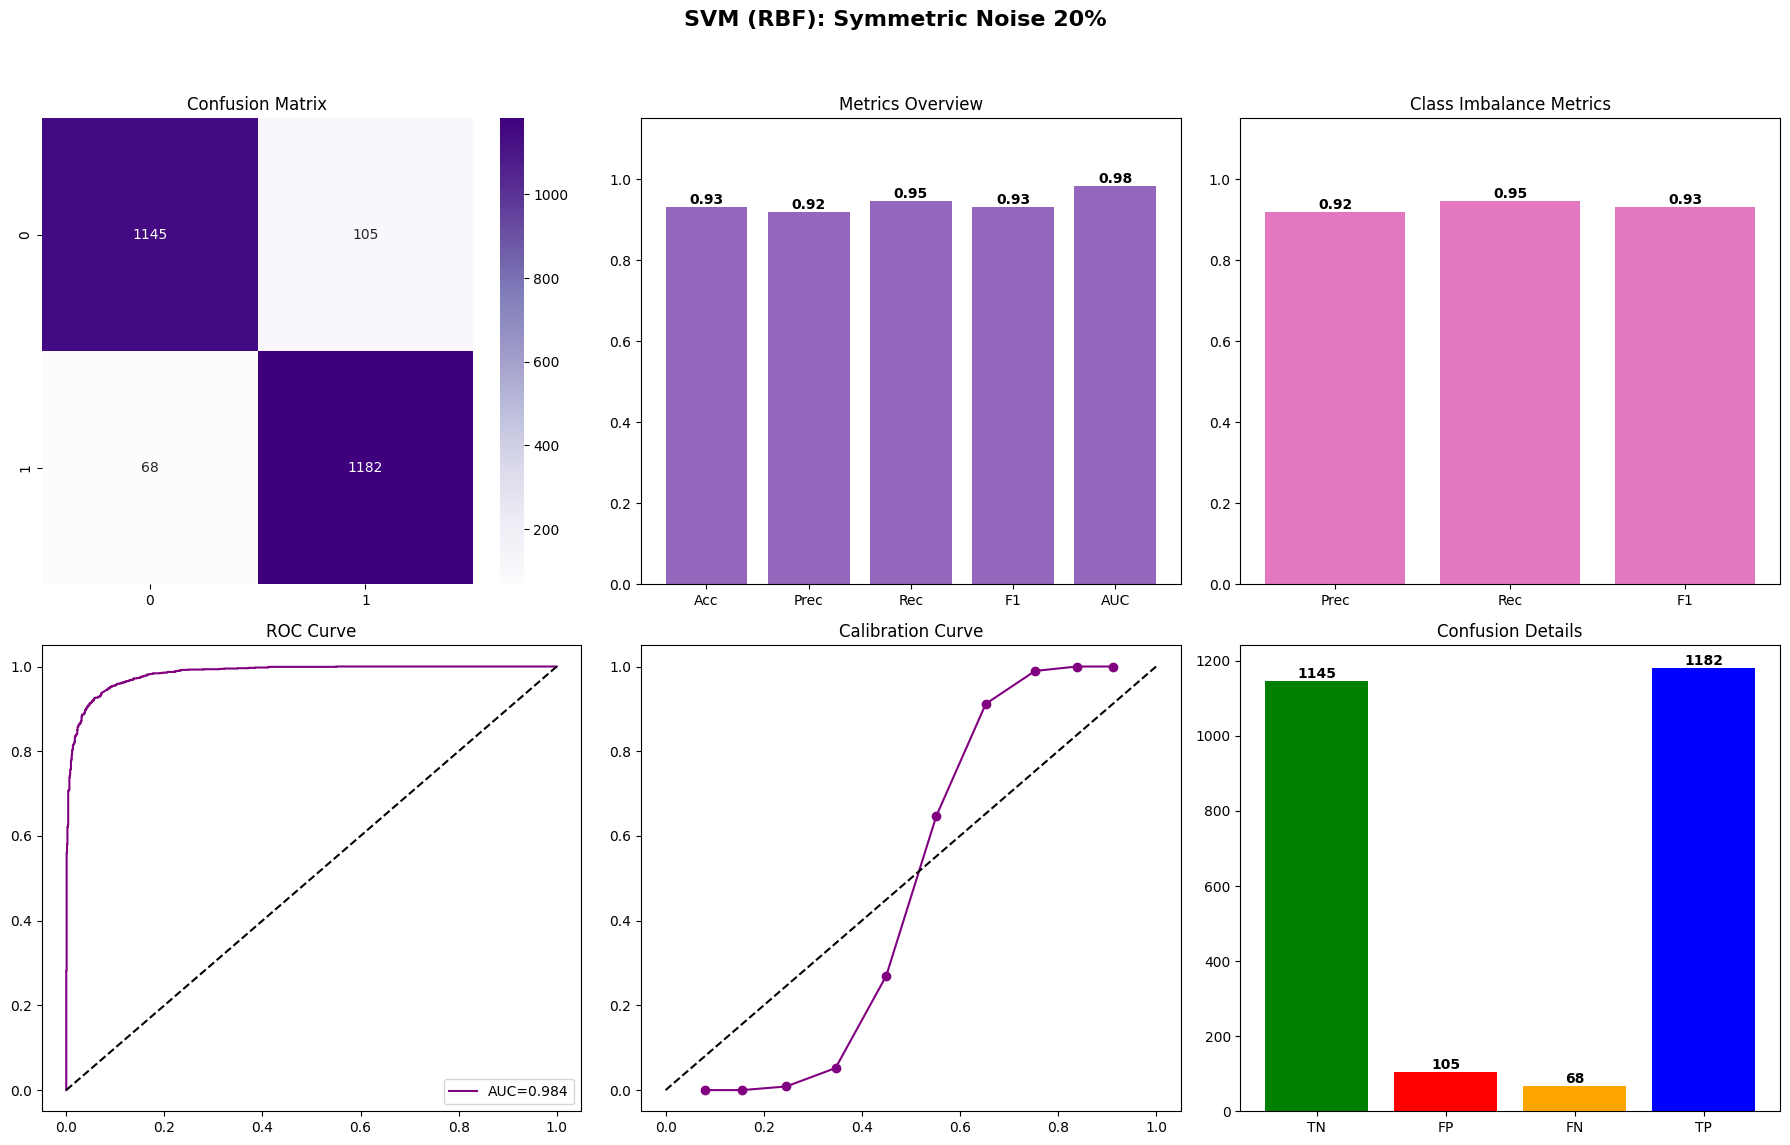

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1250
           1       0.92      0.95      0.93      1250

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500


RESULTS: Symmetric Noise 33%
Acc: 0.8932 | AUC: 0.9596 | F1: 0.8945


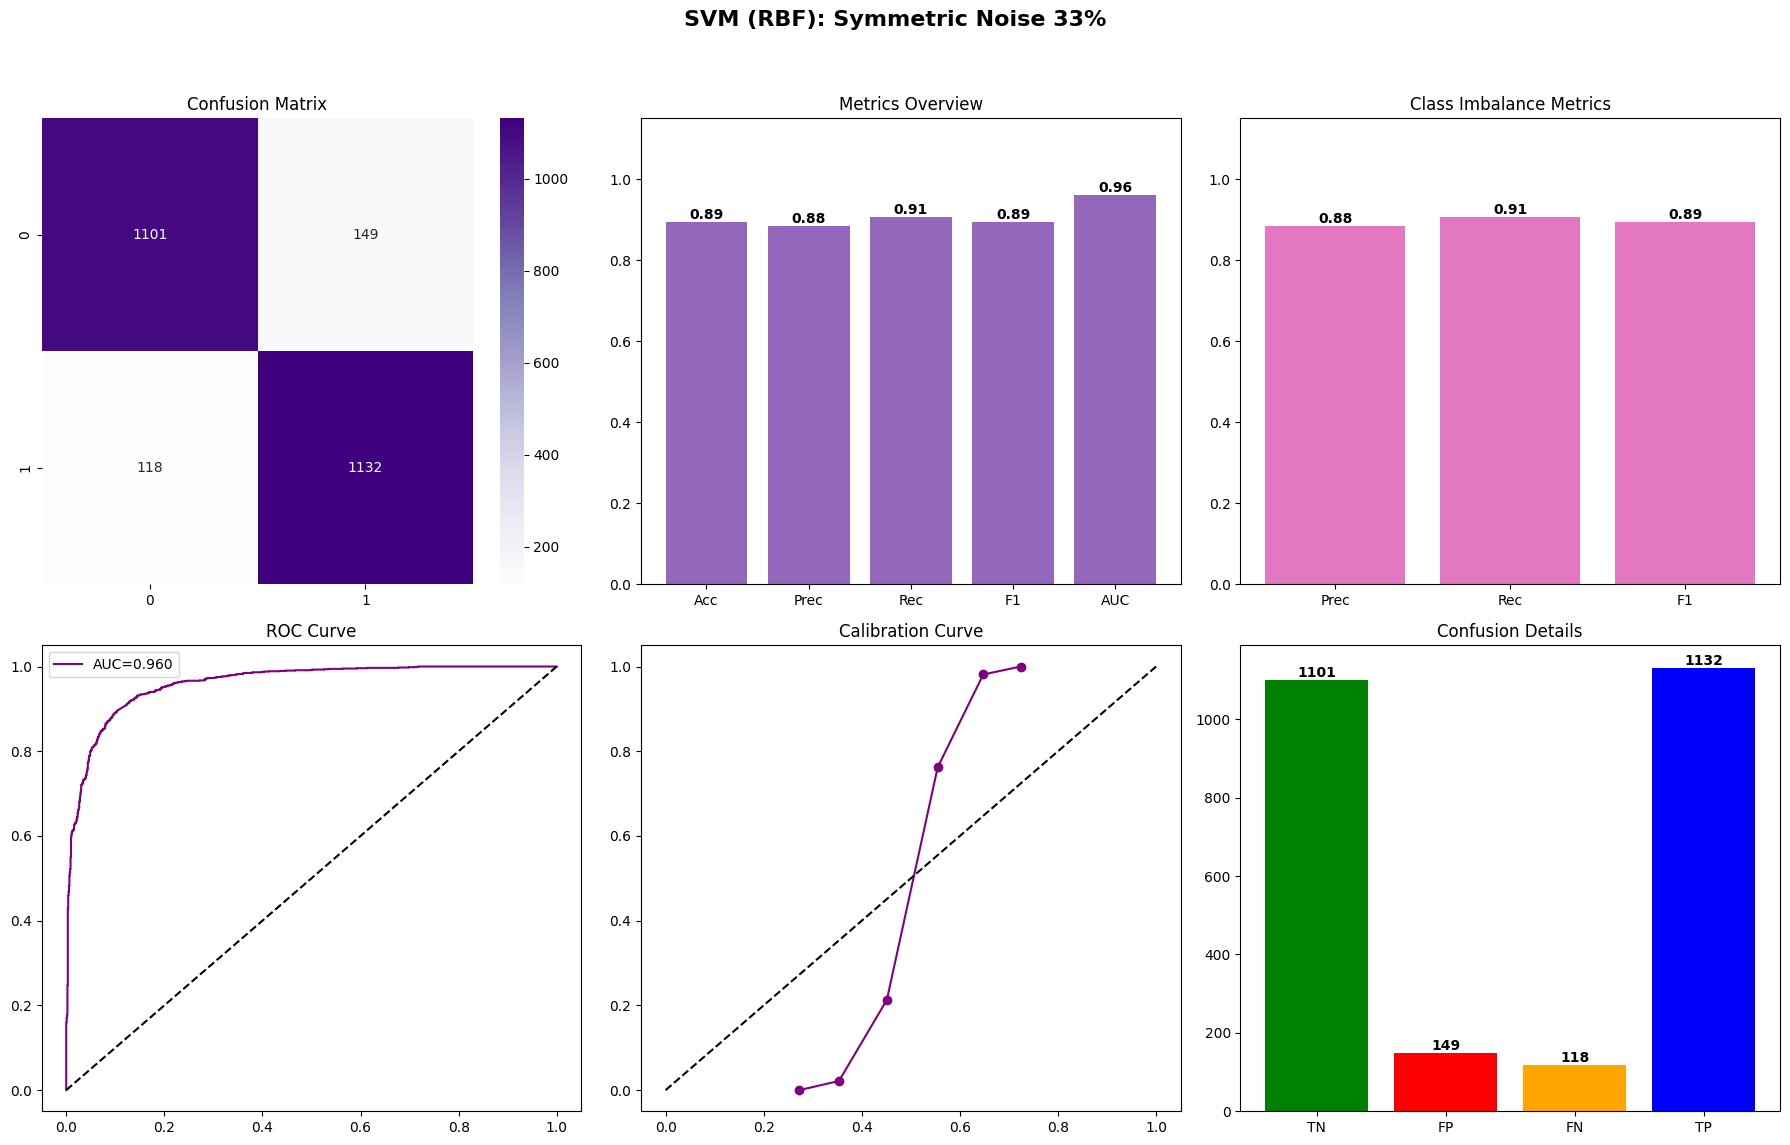

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1250
           1       0.88      0.91      0.89      1250

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500


RESULTS: Symmetric Noise 50%
Acc: 0.5196 | AUC: 0.4733 | F1: 0.4688


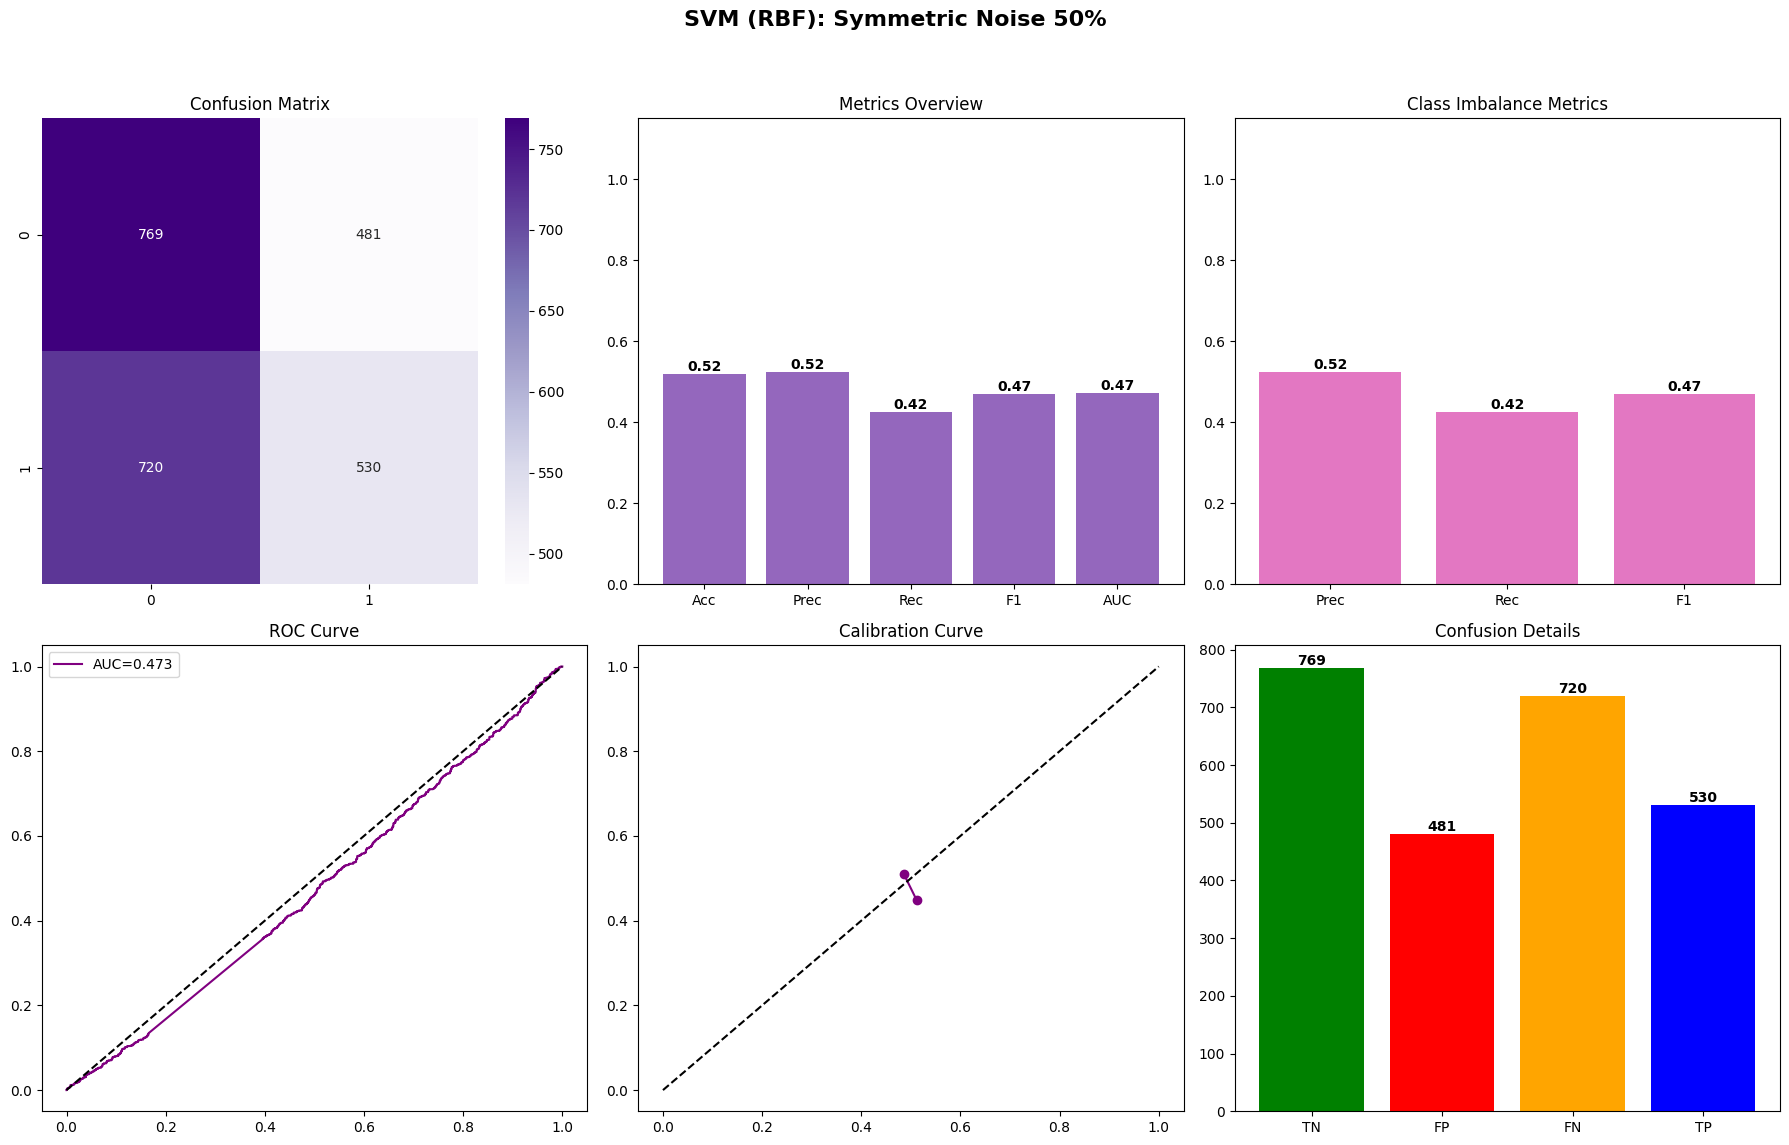

              precision    recall  f1-score   support

           0       0.52      0.62      0.56      1250
           1       0.52      0.42      0.47      1250

    accuracy                           0.52      2500
   macro avg       0.52      0.52      0.52      2500
weighted avg       0.52      0.52      0.52      2500


RESULTS: Asymmetric (0->1) Noise 10%
Acc: 0.9468 | AUC: 0.9904 | F1: 0.9486


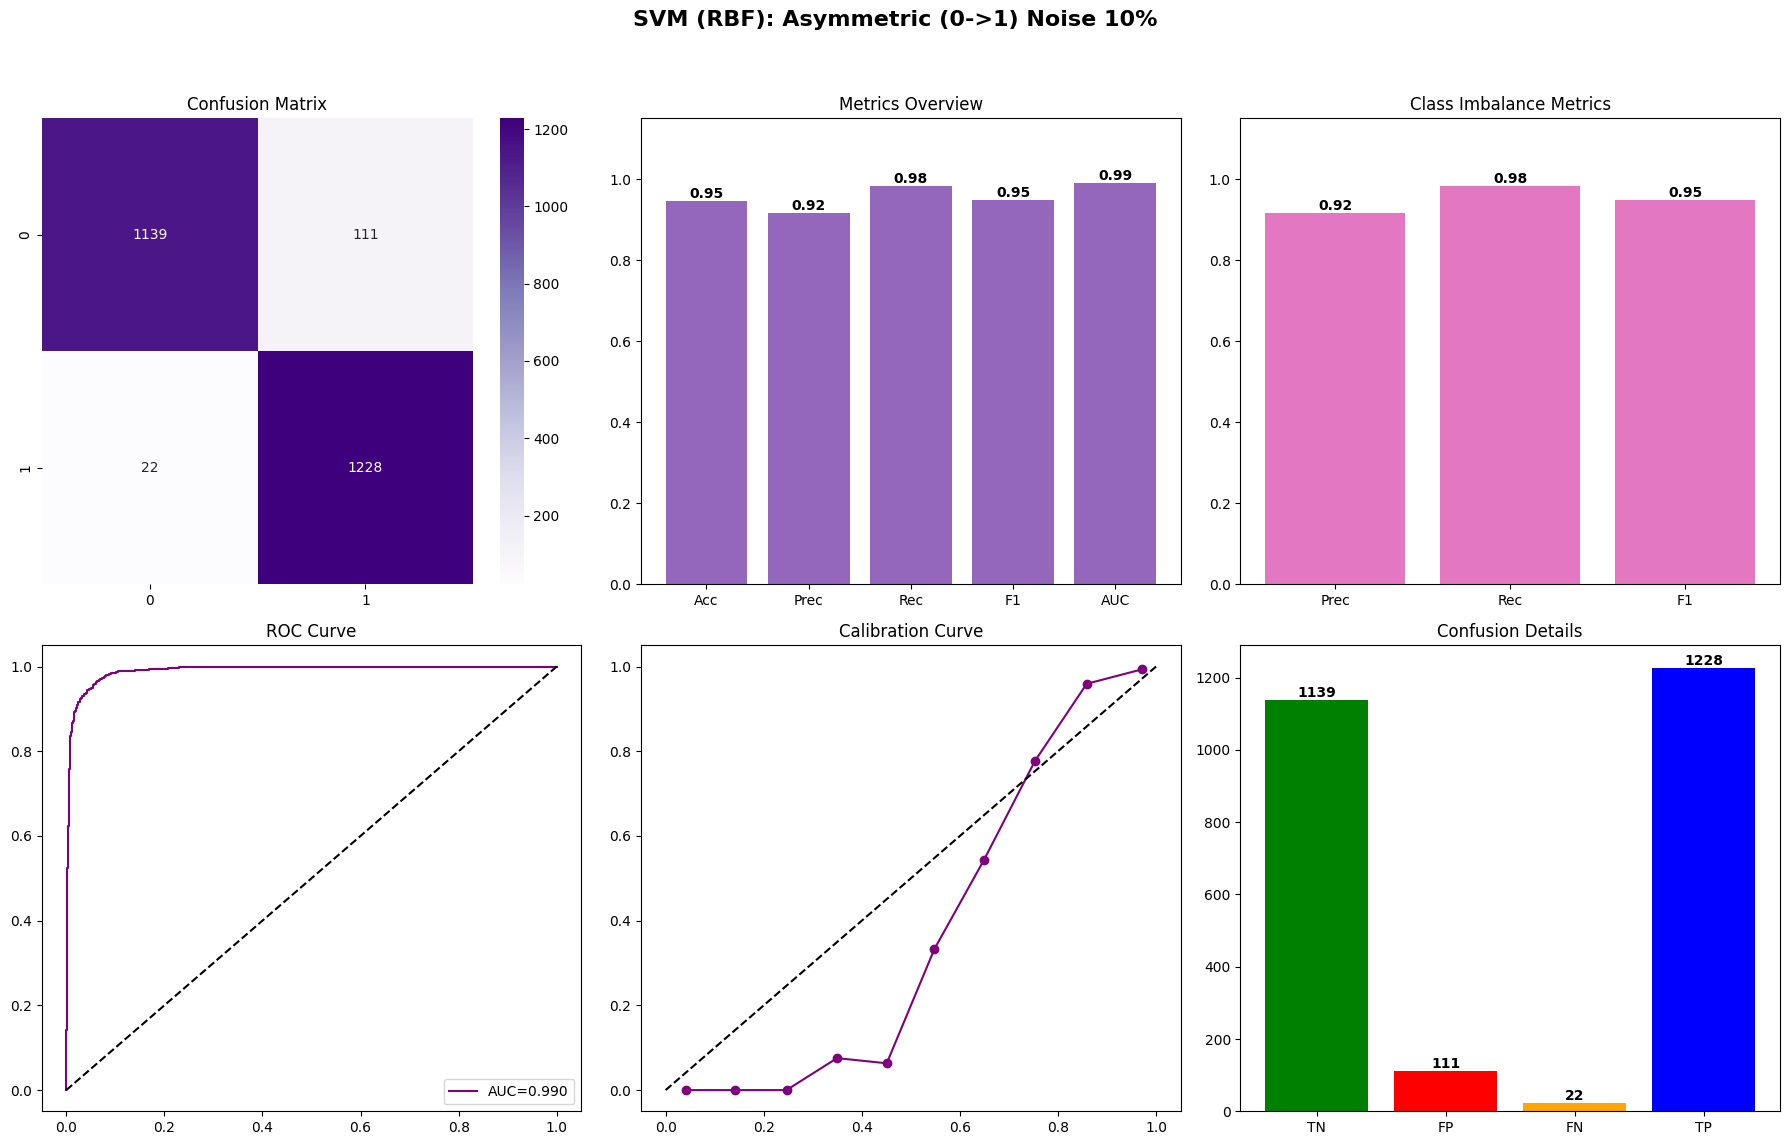

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1250
           1       0.92      0.98      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500


RESULTS: Asymmetric (0->1) Noise 20%
Acc: 0.9136 | AUC: 0.9875 | F1: 0.9195


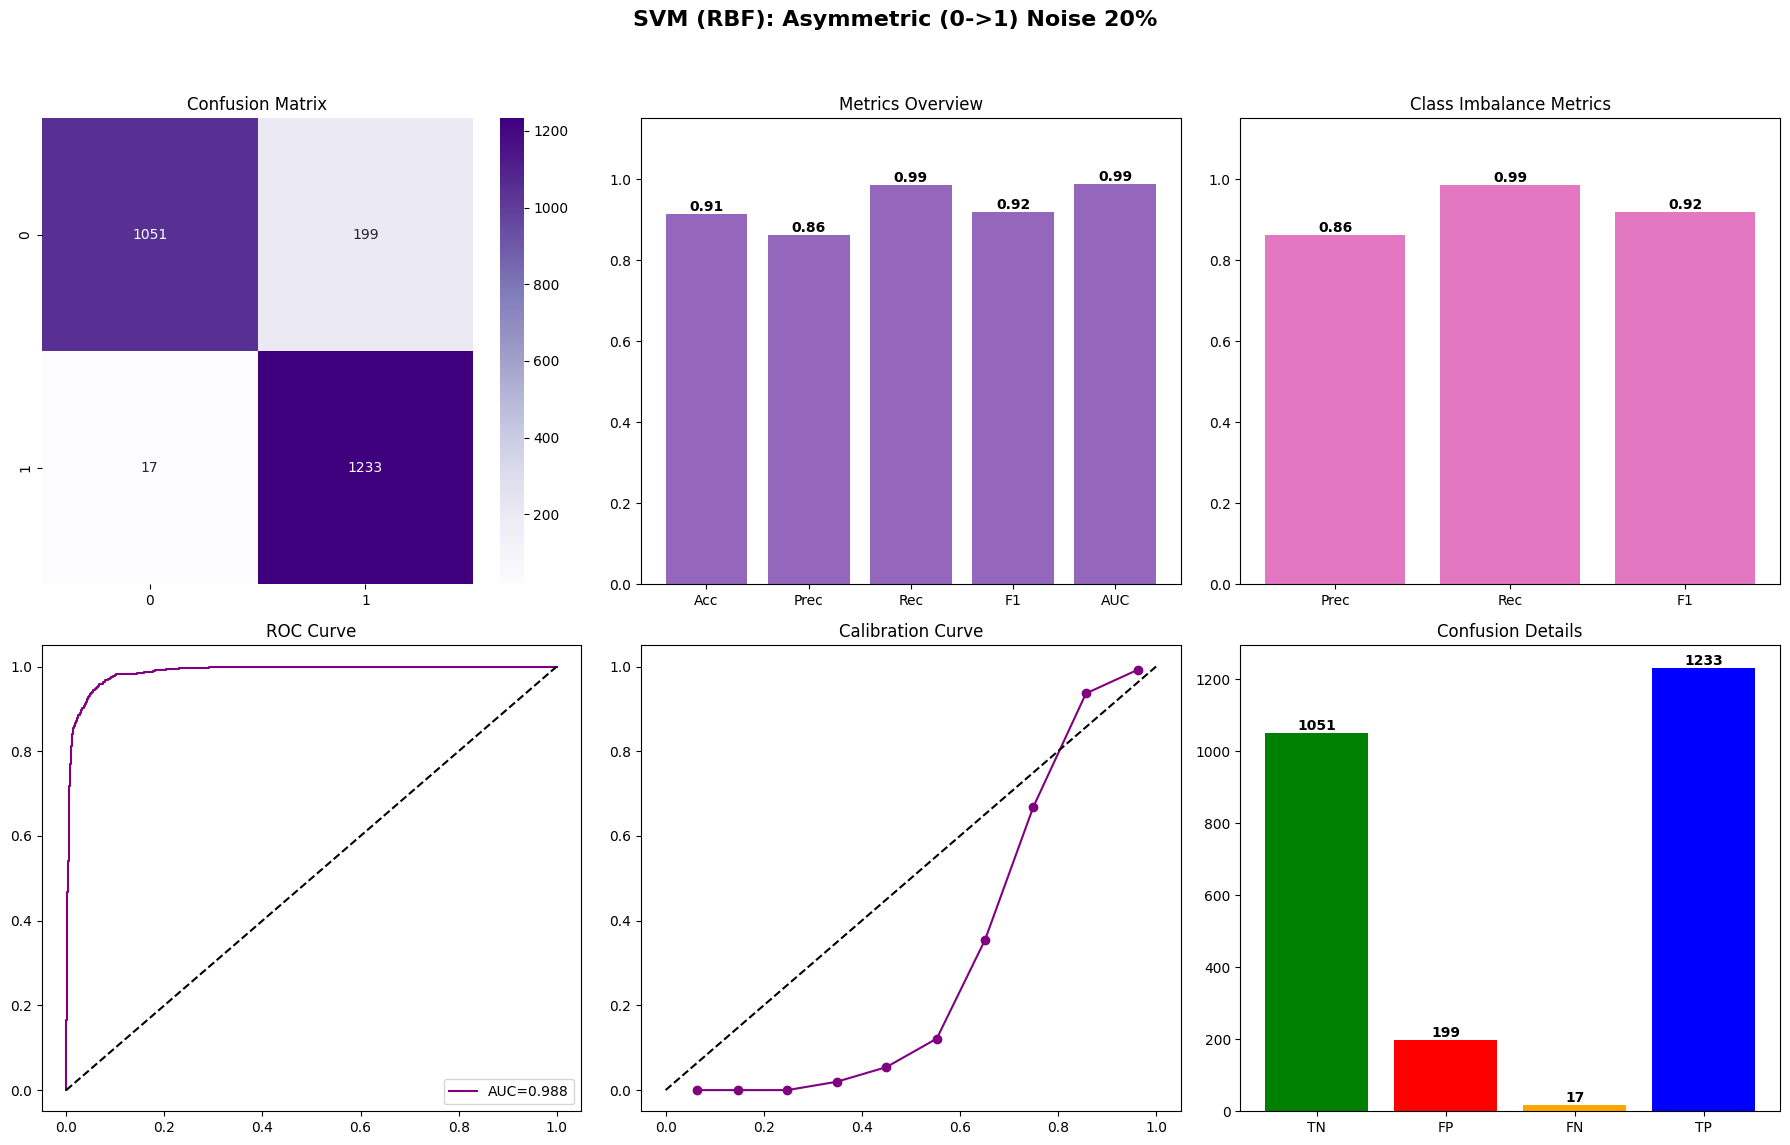

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      1250
           1       0.86      0.99      0.92      1250

    accuracy                           0.91      2500
   macro avg       0.92      0.91      0.91      2500
weighted avg       0.92      0.91      0.91      2500


RESULTS: Asymmetric (0->1) Noise 33%
Acc: 0.8488 | AUC: 0.9840 | F1: 0.8686


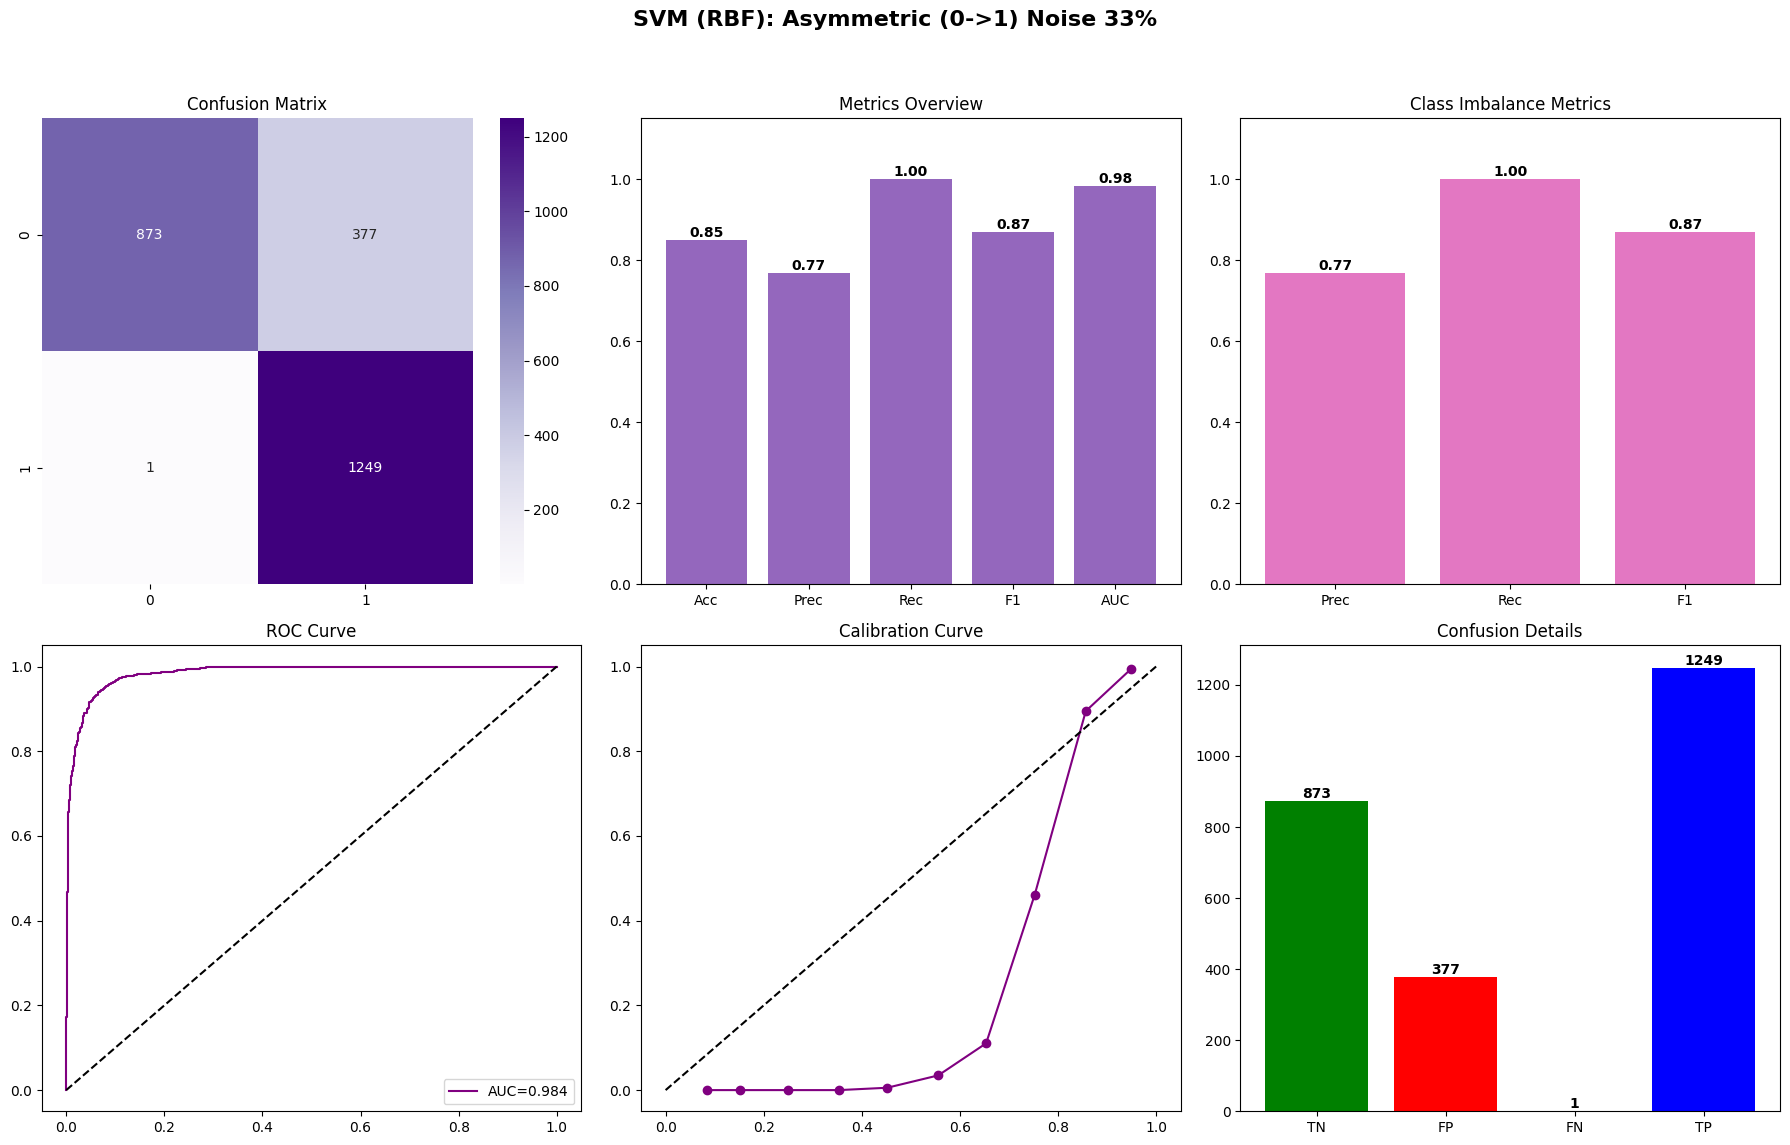

              precision    recall  f1-score   support

           0       1.00      0.70      0.82      1250
           1       0.77      1.00      0.87      1250

    accuracy                           0.85      2500
   macro avg       0.88      0.85      0.85      2500
weighted avg       0.88      0.85      0.85      2500


RESULTS: Asymmetric (0->1) Noise 50%
Acc: 0.6064 | AUC: 0.9511 | F1: 0.7176


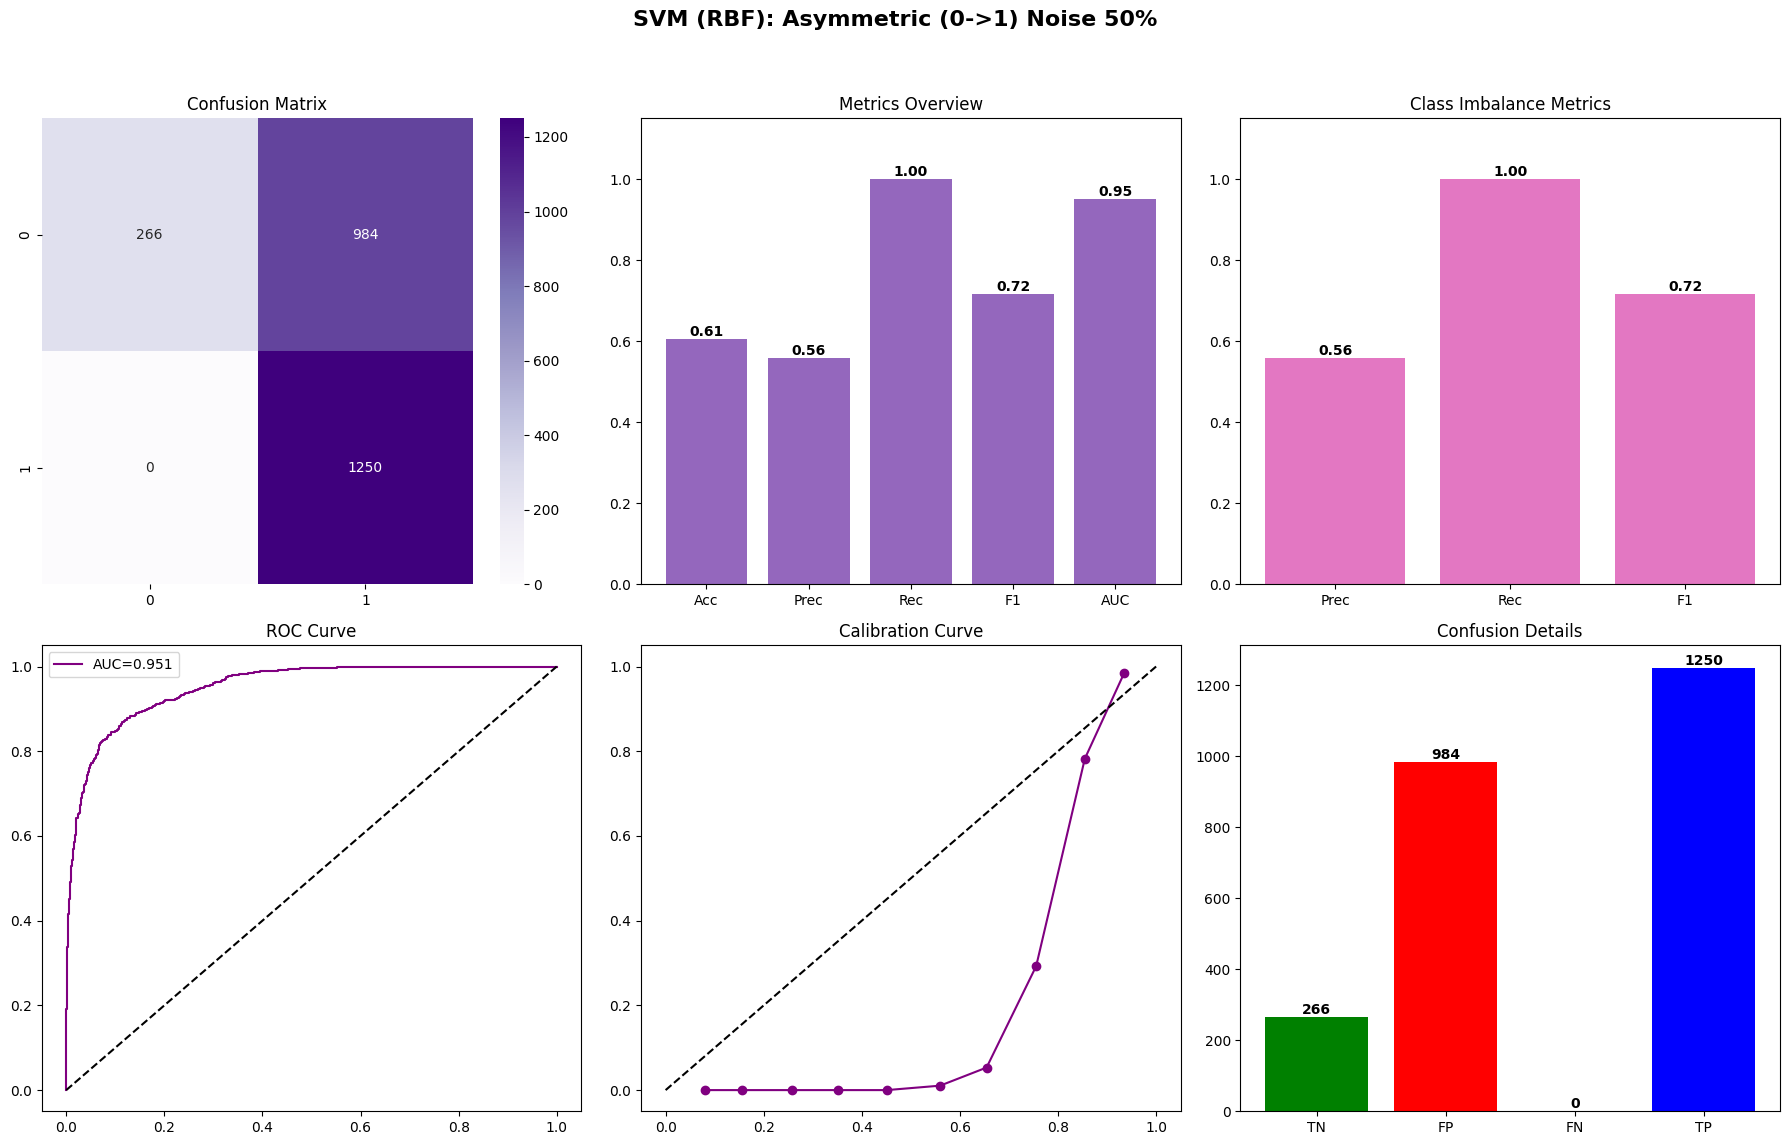

              precision    recall  f1-score   support

           0       1.00      0.21      0.35      1250
           1       0.56      1.00      0.72      1250

    accuracy                           0.61      2500
   macro avg       0.78      0.61      0.53      2500
weighted avg       0.78      0.61      0.53      2500


RESULTS: Asymmetric (1->0) Noise 10%
Acc: 0.9540 | AUC: 0.9925 | F1: 0.9542


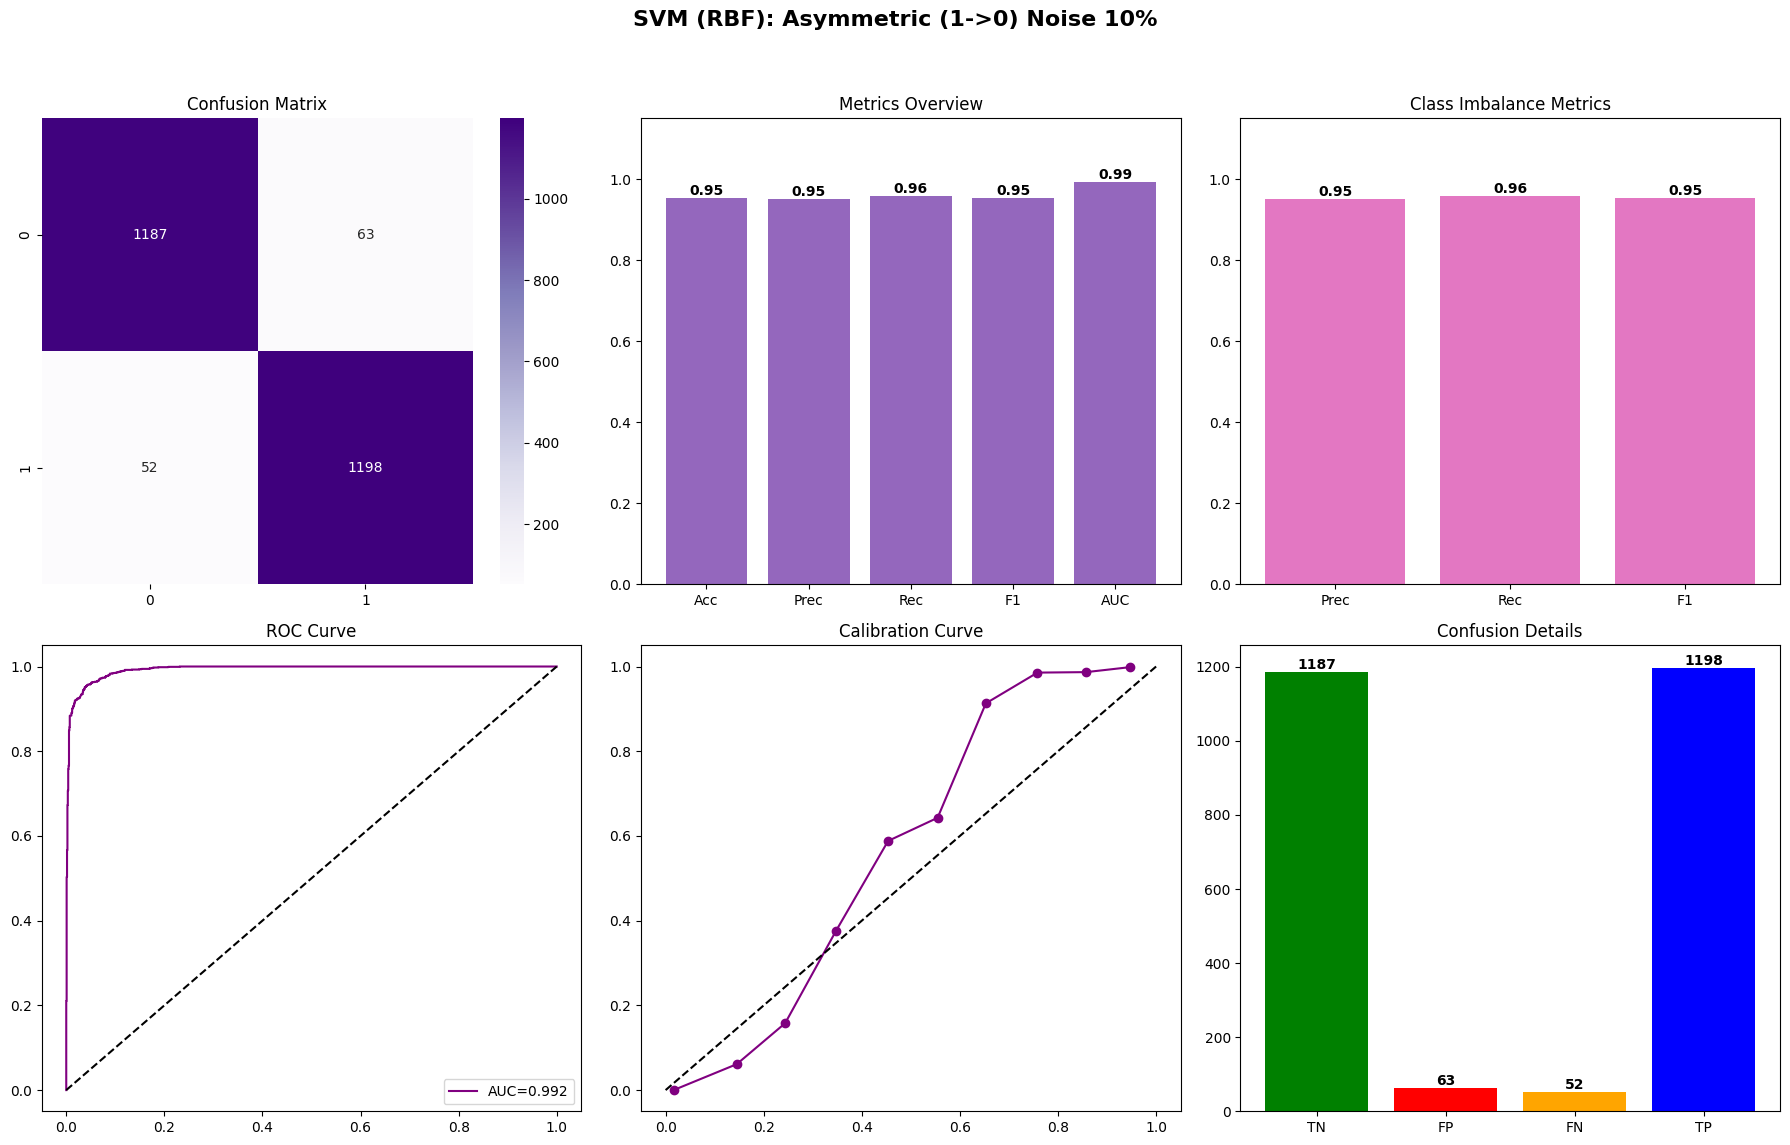

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1250
           1       0.95      0.96      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500


RESULTS: Asymmetric (1->0) Noise 20%
Acc: 0.9452 | AUC: 0.9904 | F1: 0.9442


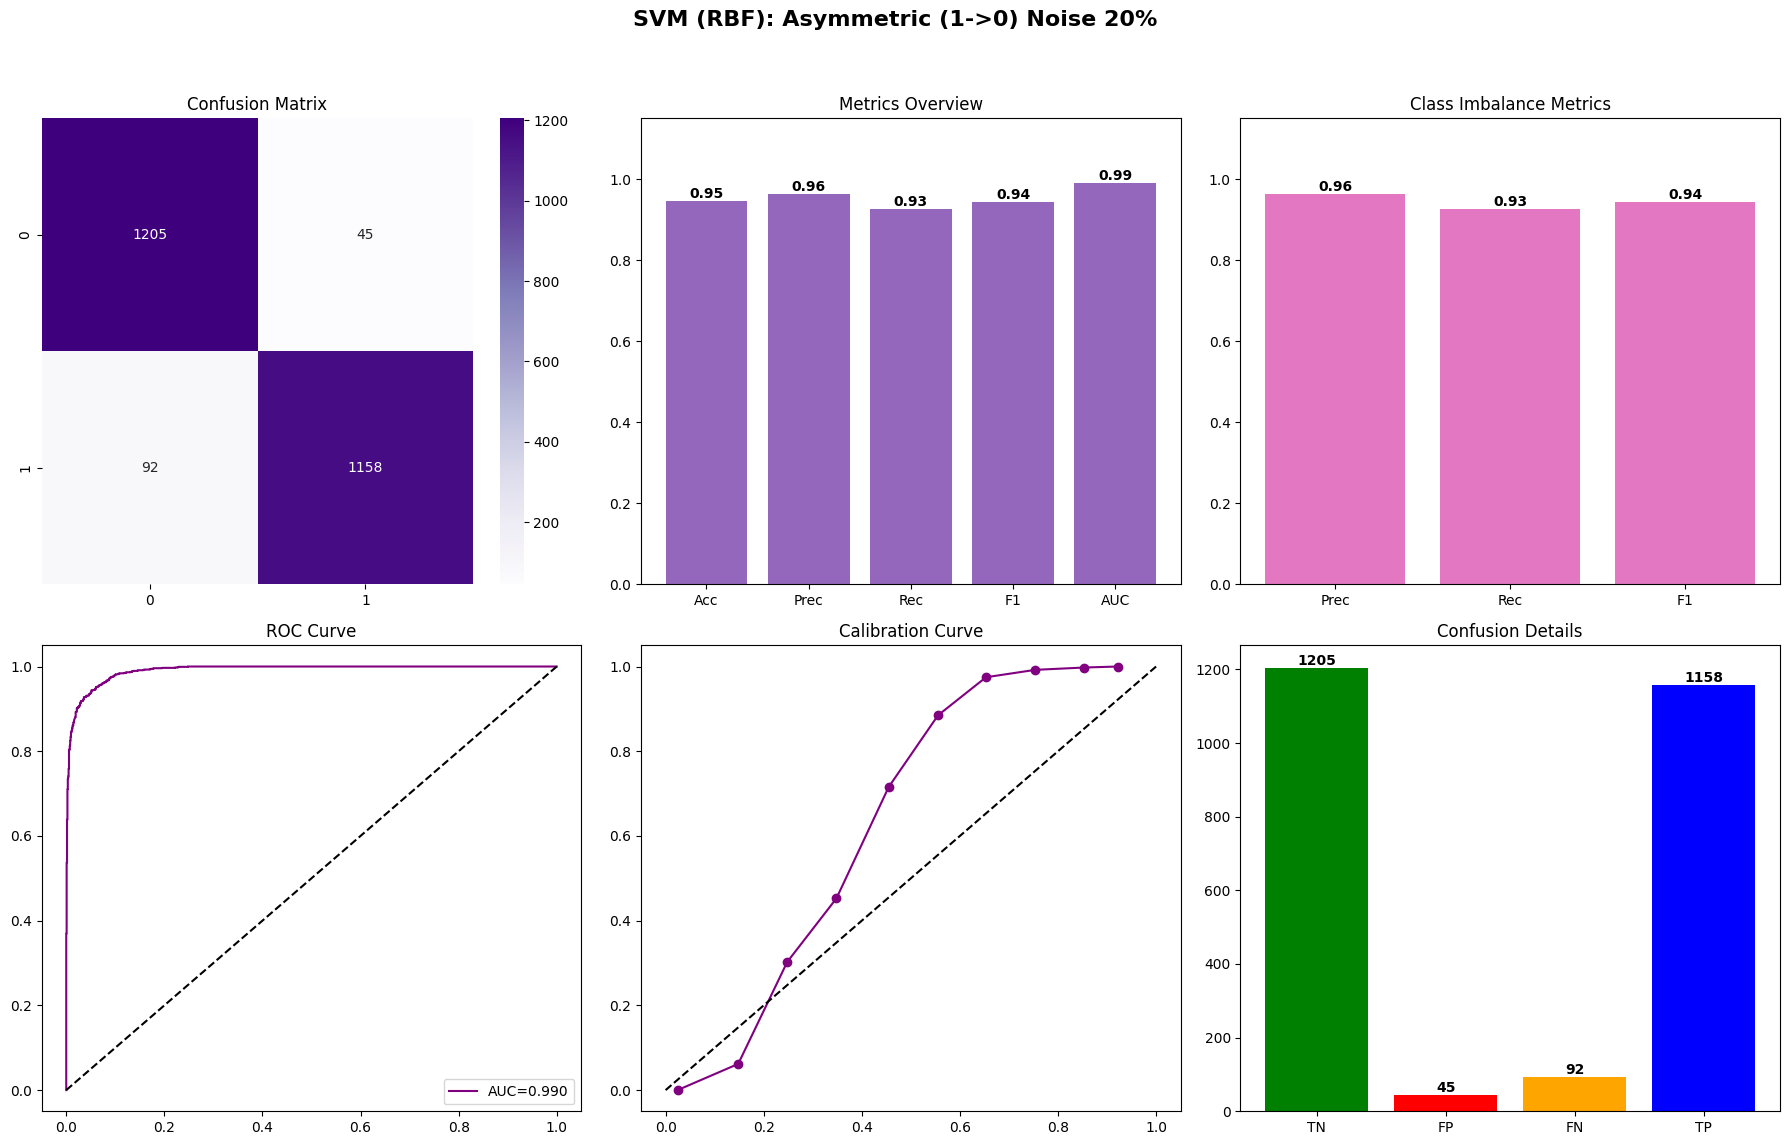

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1250
           1       0.96      0.93      0.94      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500


RESULTS: Asymmetric (1->0) Noise 33%
Acc: 0.8916 | AUC: 0.9846 | F1: 0.8807


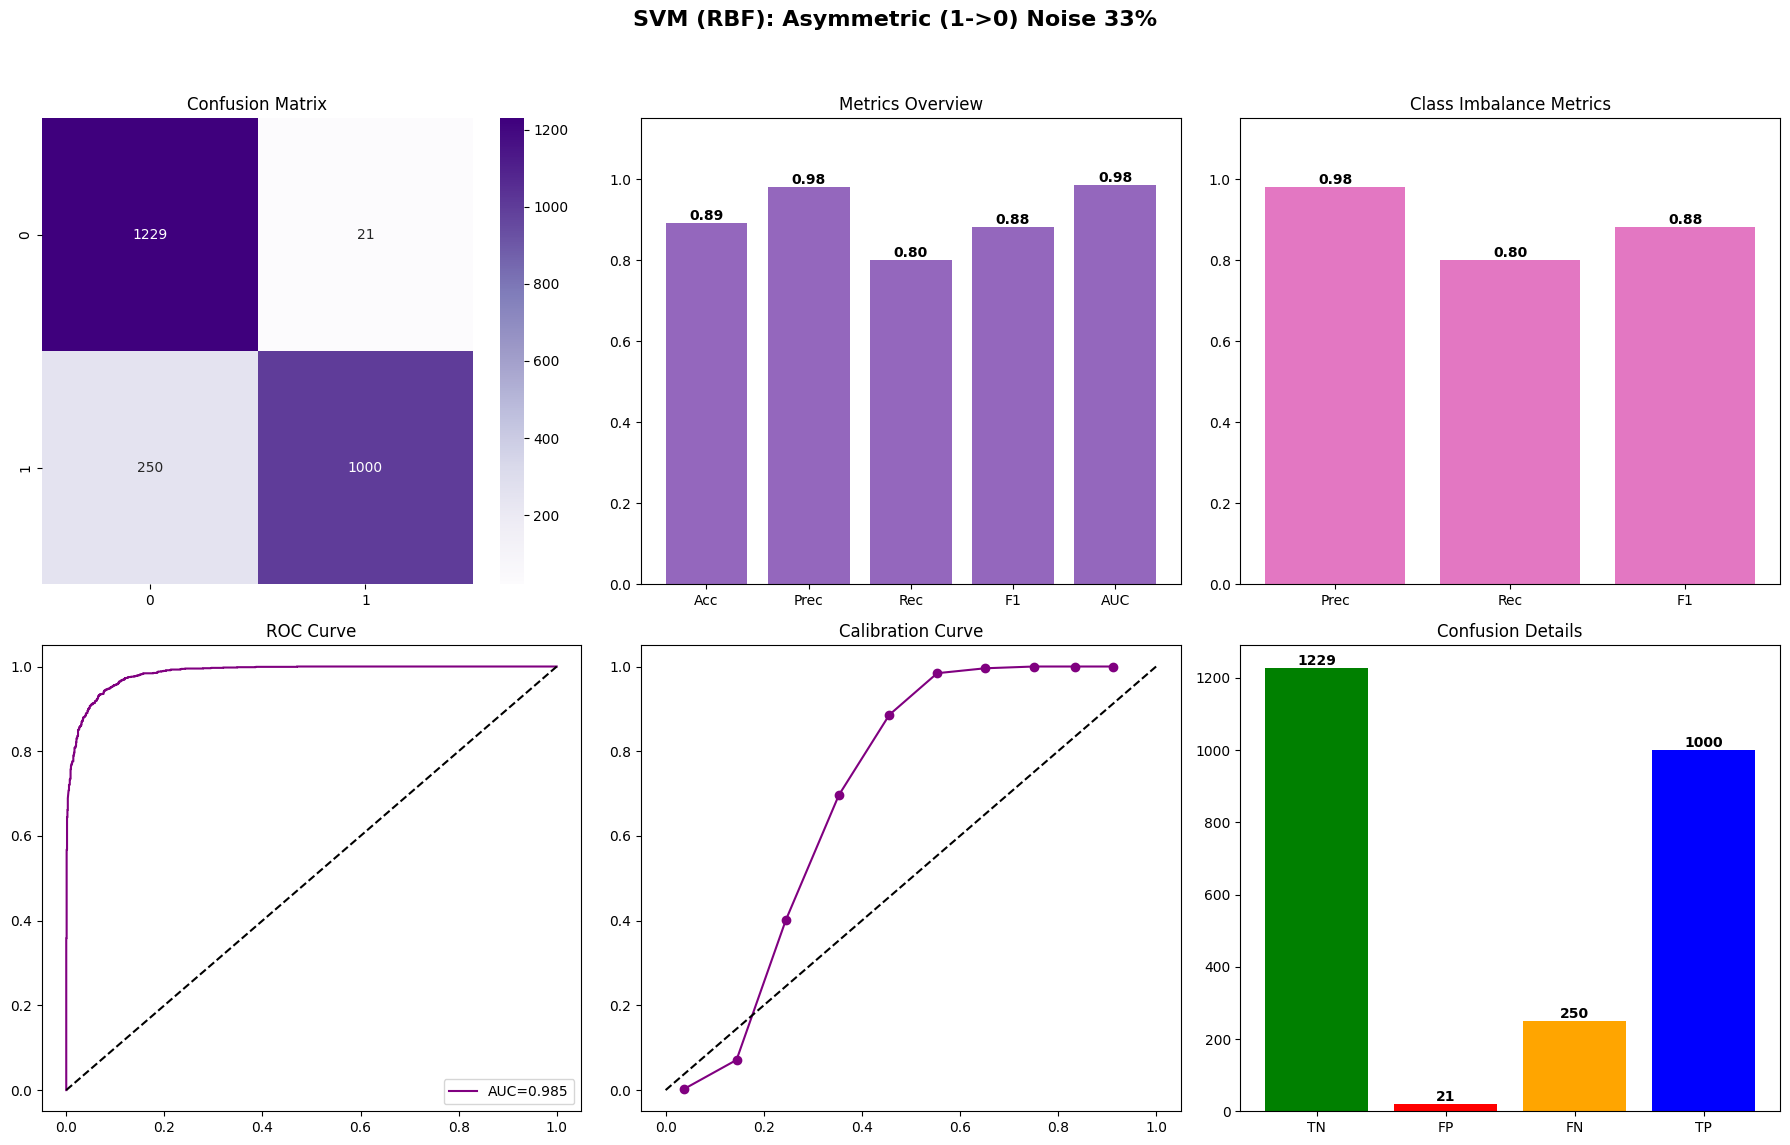

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1250
           1       0.98      0.80      0.88      1250

    accuracy                           0.89      2500
   macro avg       0.91      0.89      0.89      2500
weighted avg       0.91      0.89      0.89      2500


RESULTS: Asymmetric (1->0) Noise 50%
Acc: 0.5740 | AUC: 0.9488 | F1: 0.2578


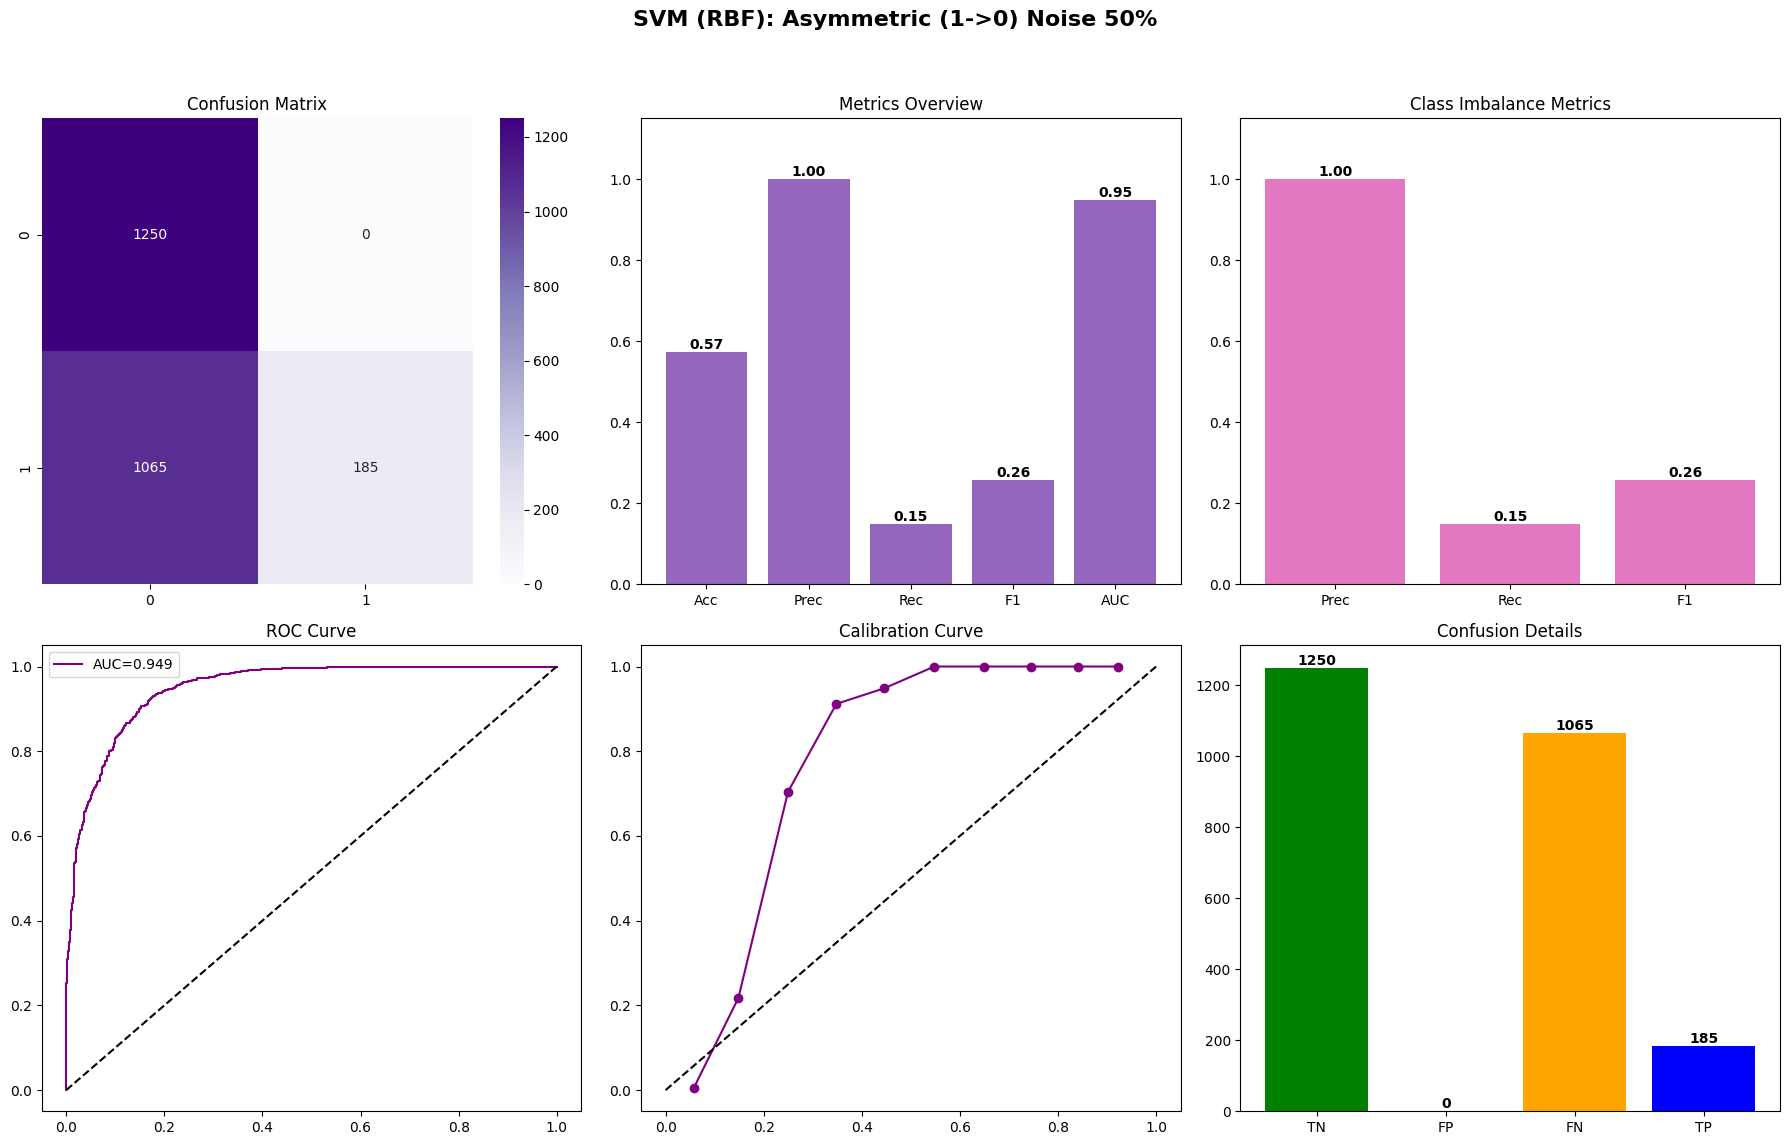

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1250
           1       1.00      0.15      0.26      1250

    accuracy                           0.57      2500
   macro avg       0.77      0.57      0.48      2500
weighted avg       0.77      0.57      0.48      2500


RESULTS: Random Flip Noise 10%
Acc: 0.9432 | AUC: 0.9887 | F1: 0.9441


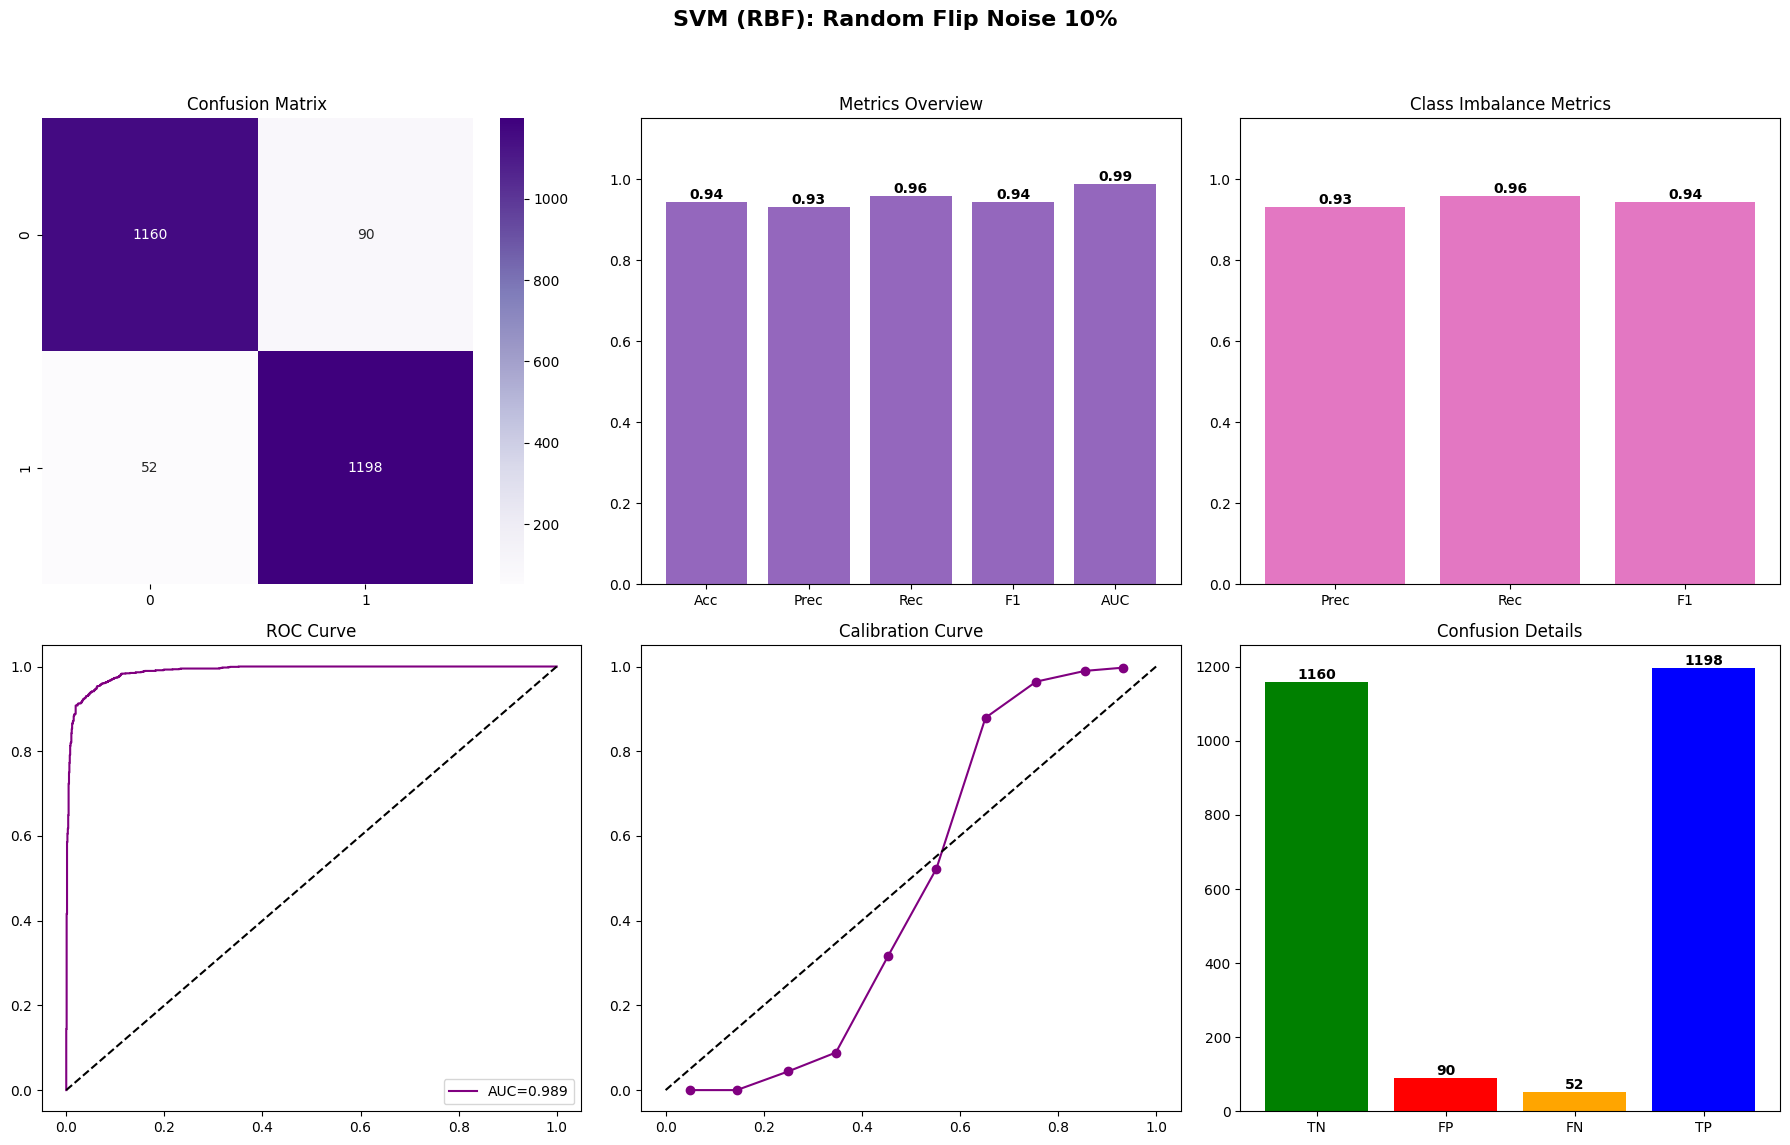

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1250
           1       0.93      0.96      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500


RESULTS: Random Flip Noise 20%
Acc: 0.9308 | AUC: 0.9840 | F1: 0.9318


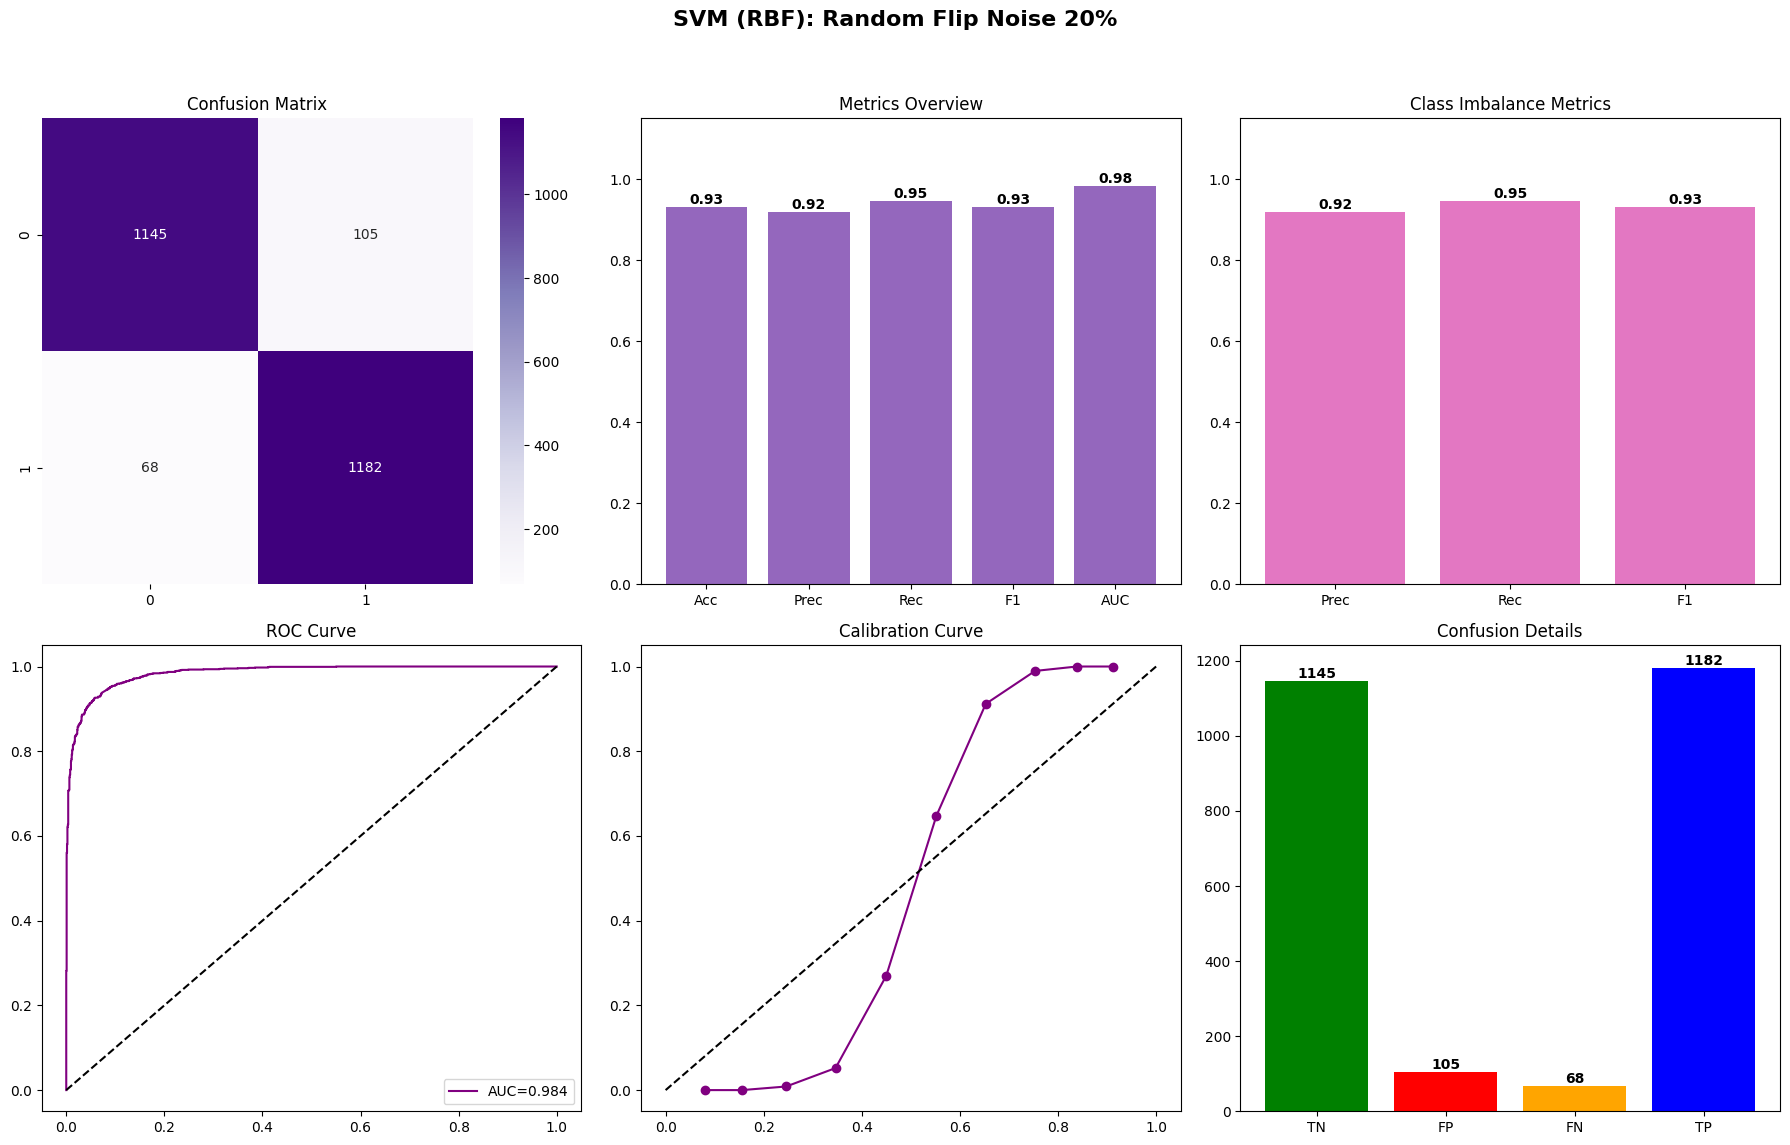

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1250
           1       0.92      0.95      0.93      1250

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500


RESULTS: Random Flip Noise 33%
Acc: 0.8932 | AUC: 0.9596 | F1: 0.8945


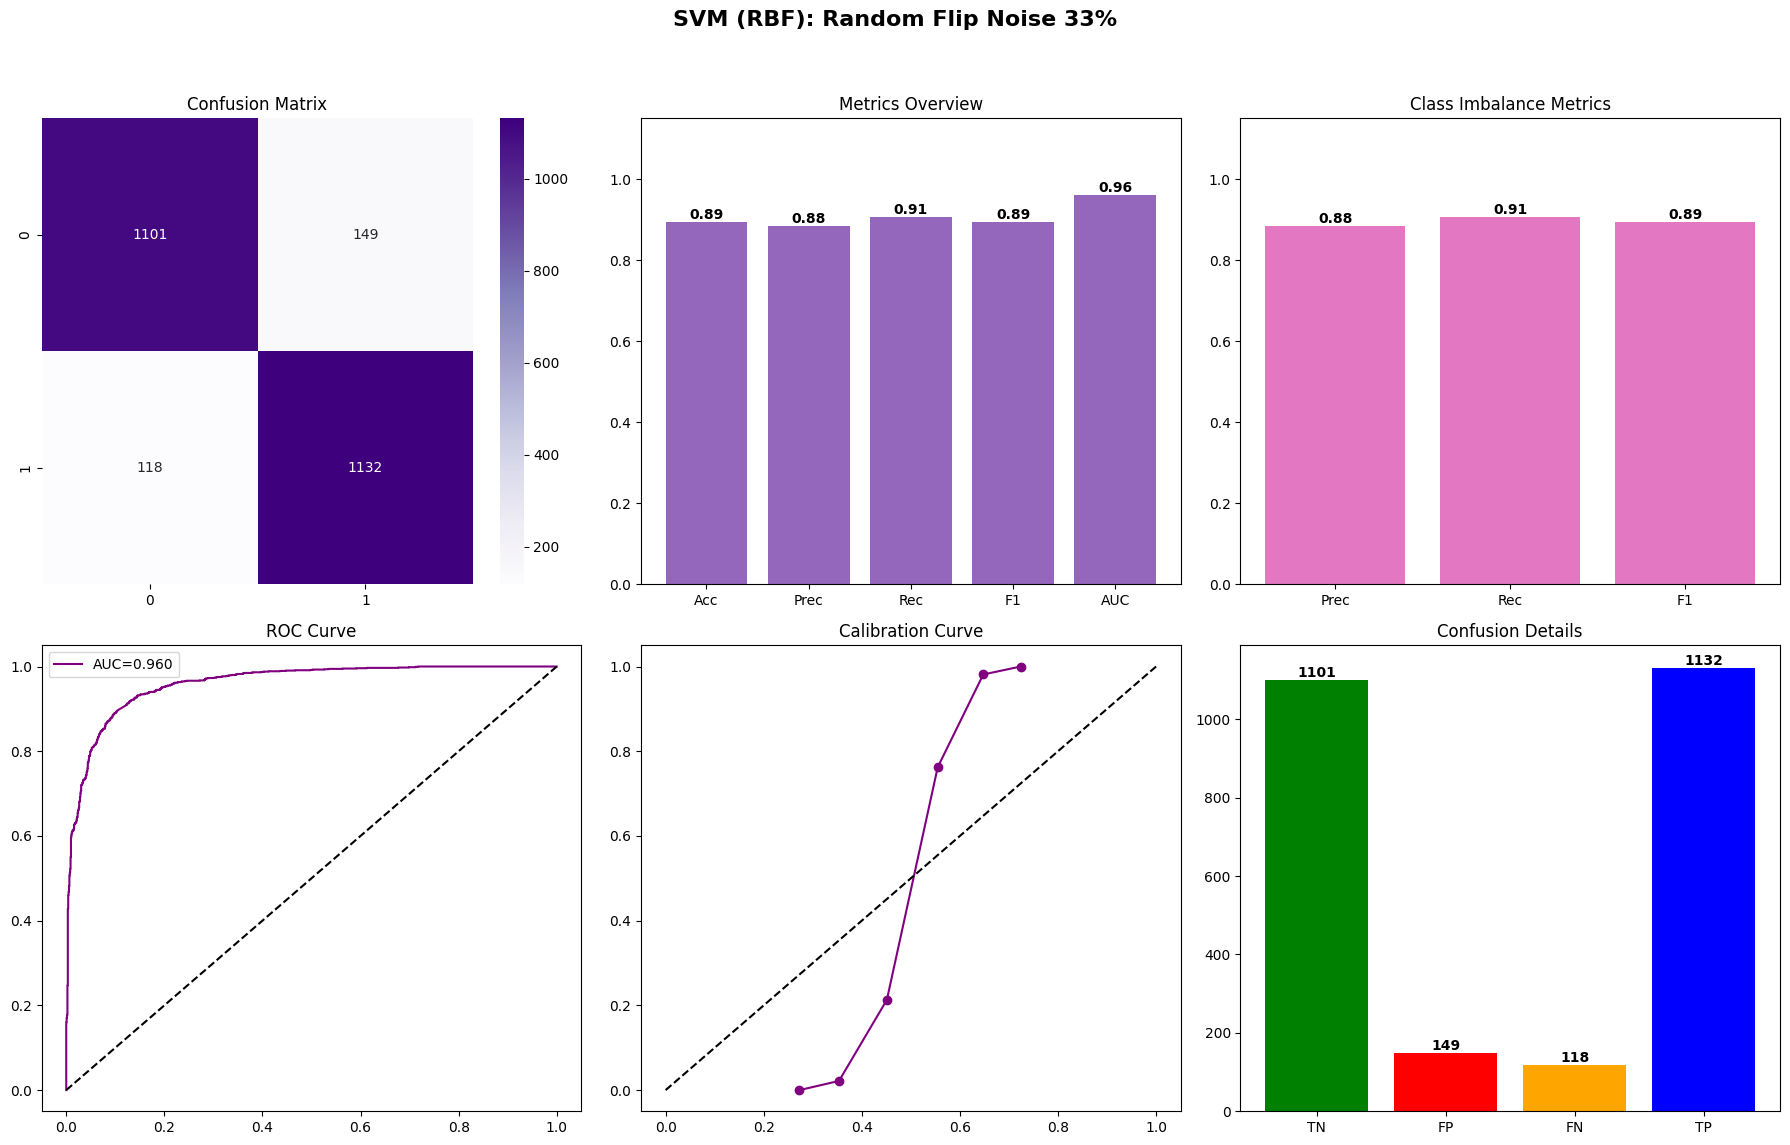

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1250
           1       0.88      0.91      0.89      1250

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500


RESULTS: Random Flip Noise 50%
Acc: 0.5196 | AUC: 0.4733 | F1: 0.4688


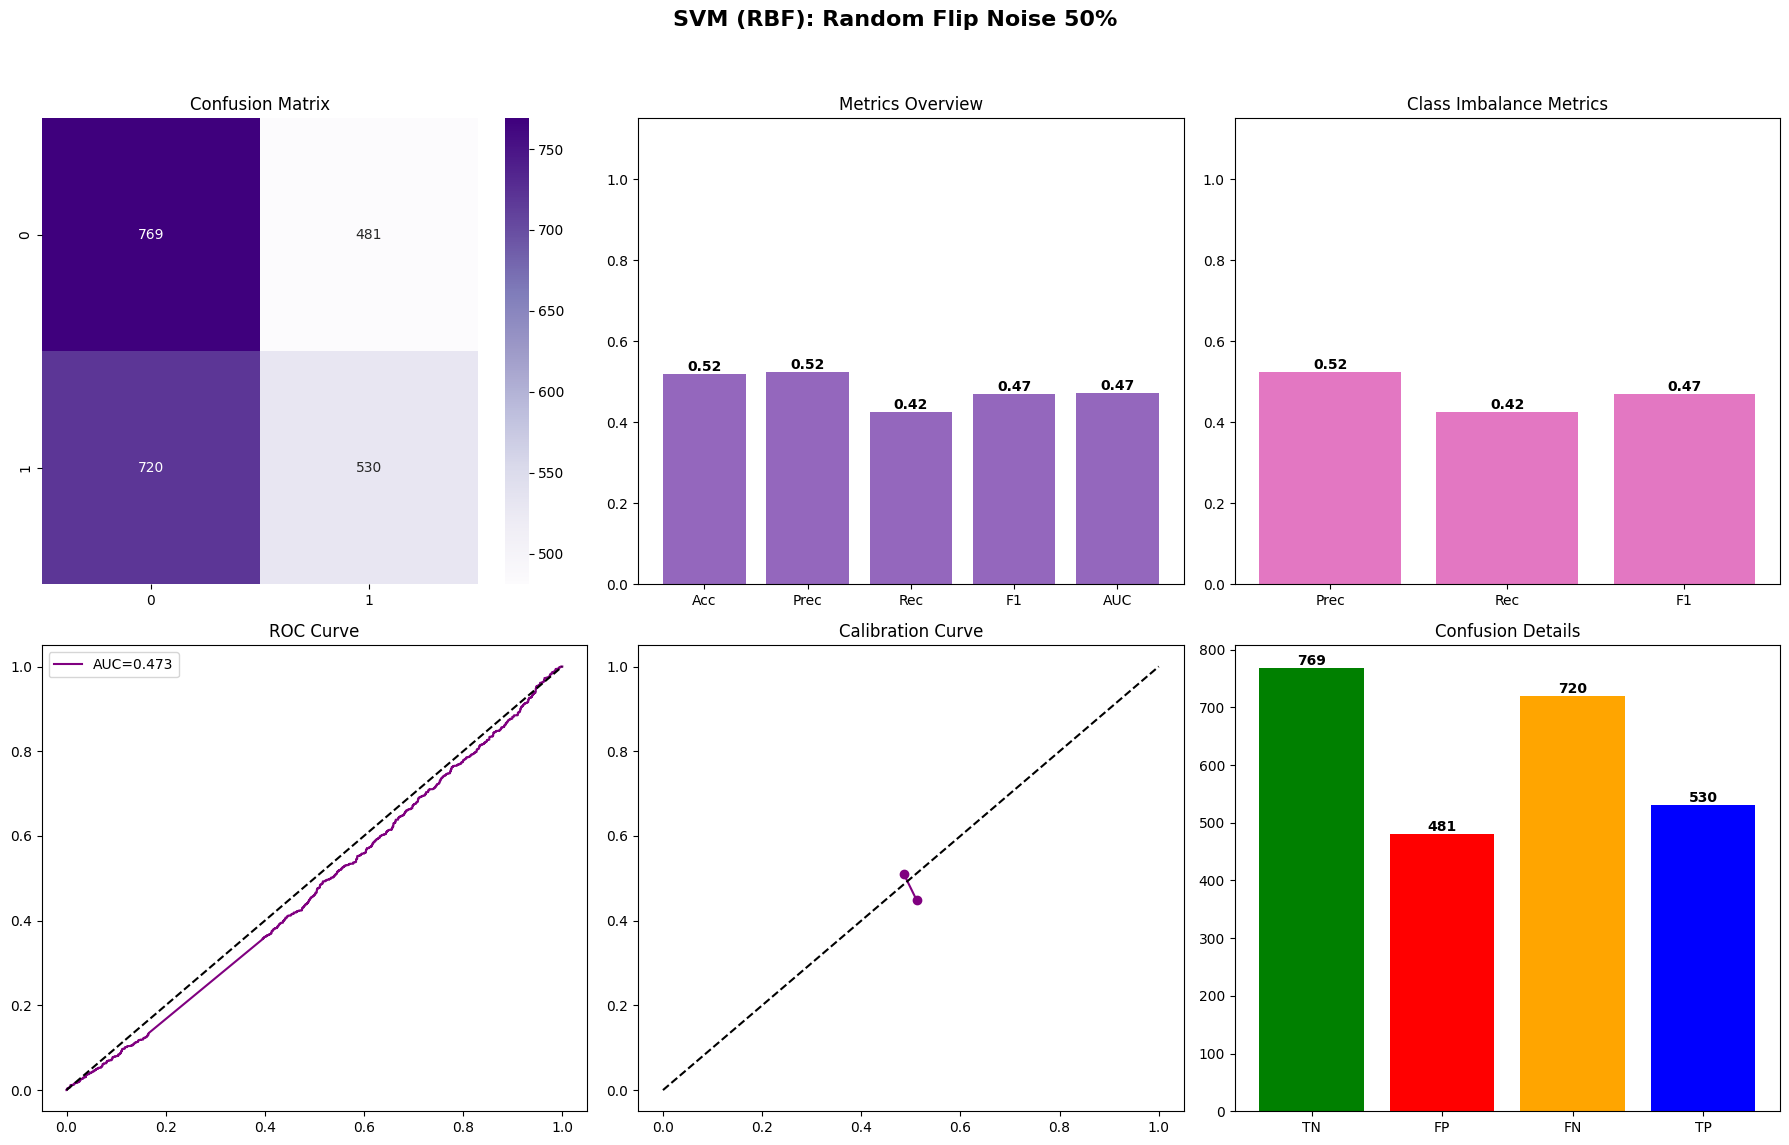

              precision    recall  f1-score   support

           0       0.52      0.62      0.56      1250
           1       0.52      0.42      0.47      1250

    accuracy                           0.52      2500
   macro avg       0.52      0.52      0.52      2500
weighted avg       0.52      0.52      0.52      2500


RESULTS: Trans Matrix (0>1=20%, 1>0=5%)
Acc: 0.9188 | AUC: 0.9873 | F1: 0.9240


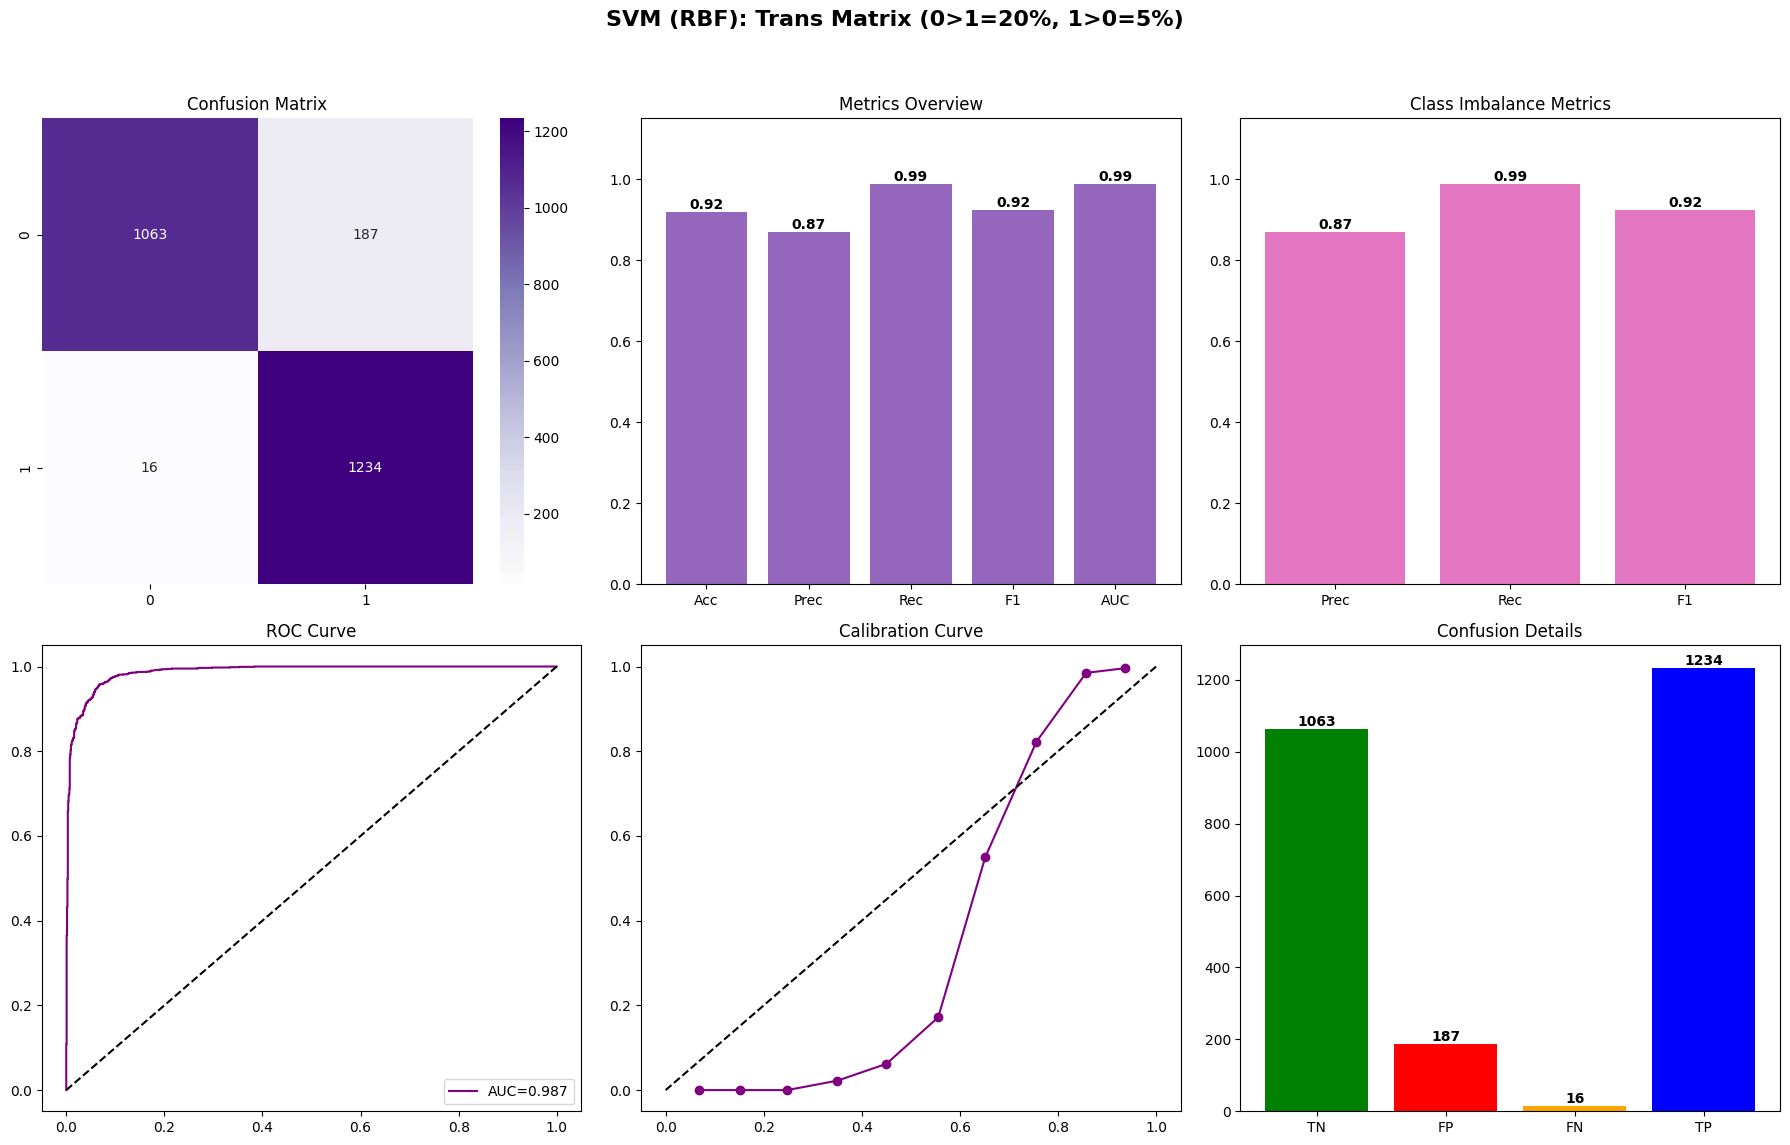

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1250
           1       0.87      0.99      0.92      1250

    accuracy                           0.92      2500
   macro avg       0.93      0.92      0.92      2500
weighted avg       0.93      0.92      0.92      2500


RESULTS: Trans Matrix (0>1=5%, 1>0=20%)
Acc: 0.9412 | AUC: 0.9882 | F1: 0.9398


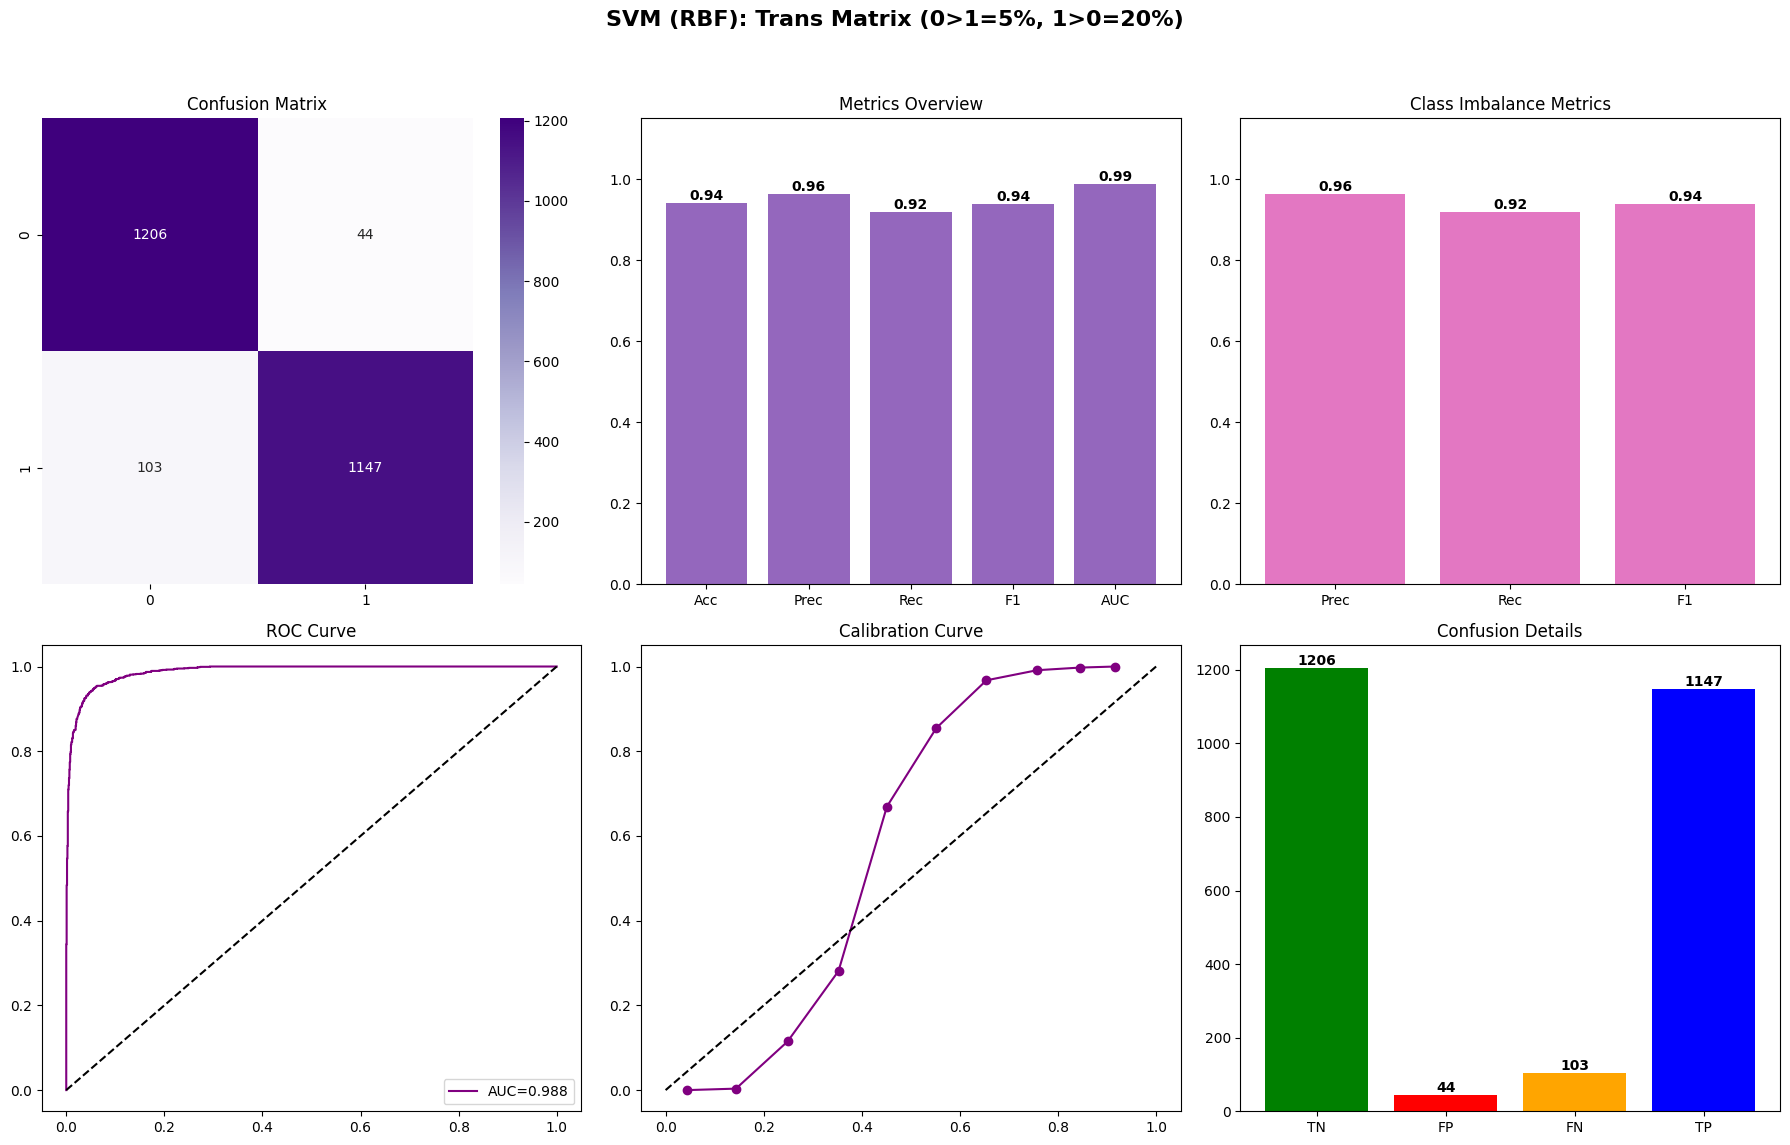

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1250
           1       0.96      0.92      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500


RESULTS: Trans Matrix (0>1=50%, 1>0=10%)
Acc: 0.5856 | AUC: 0.9204 | F1: 0.7070


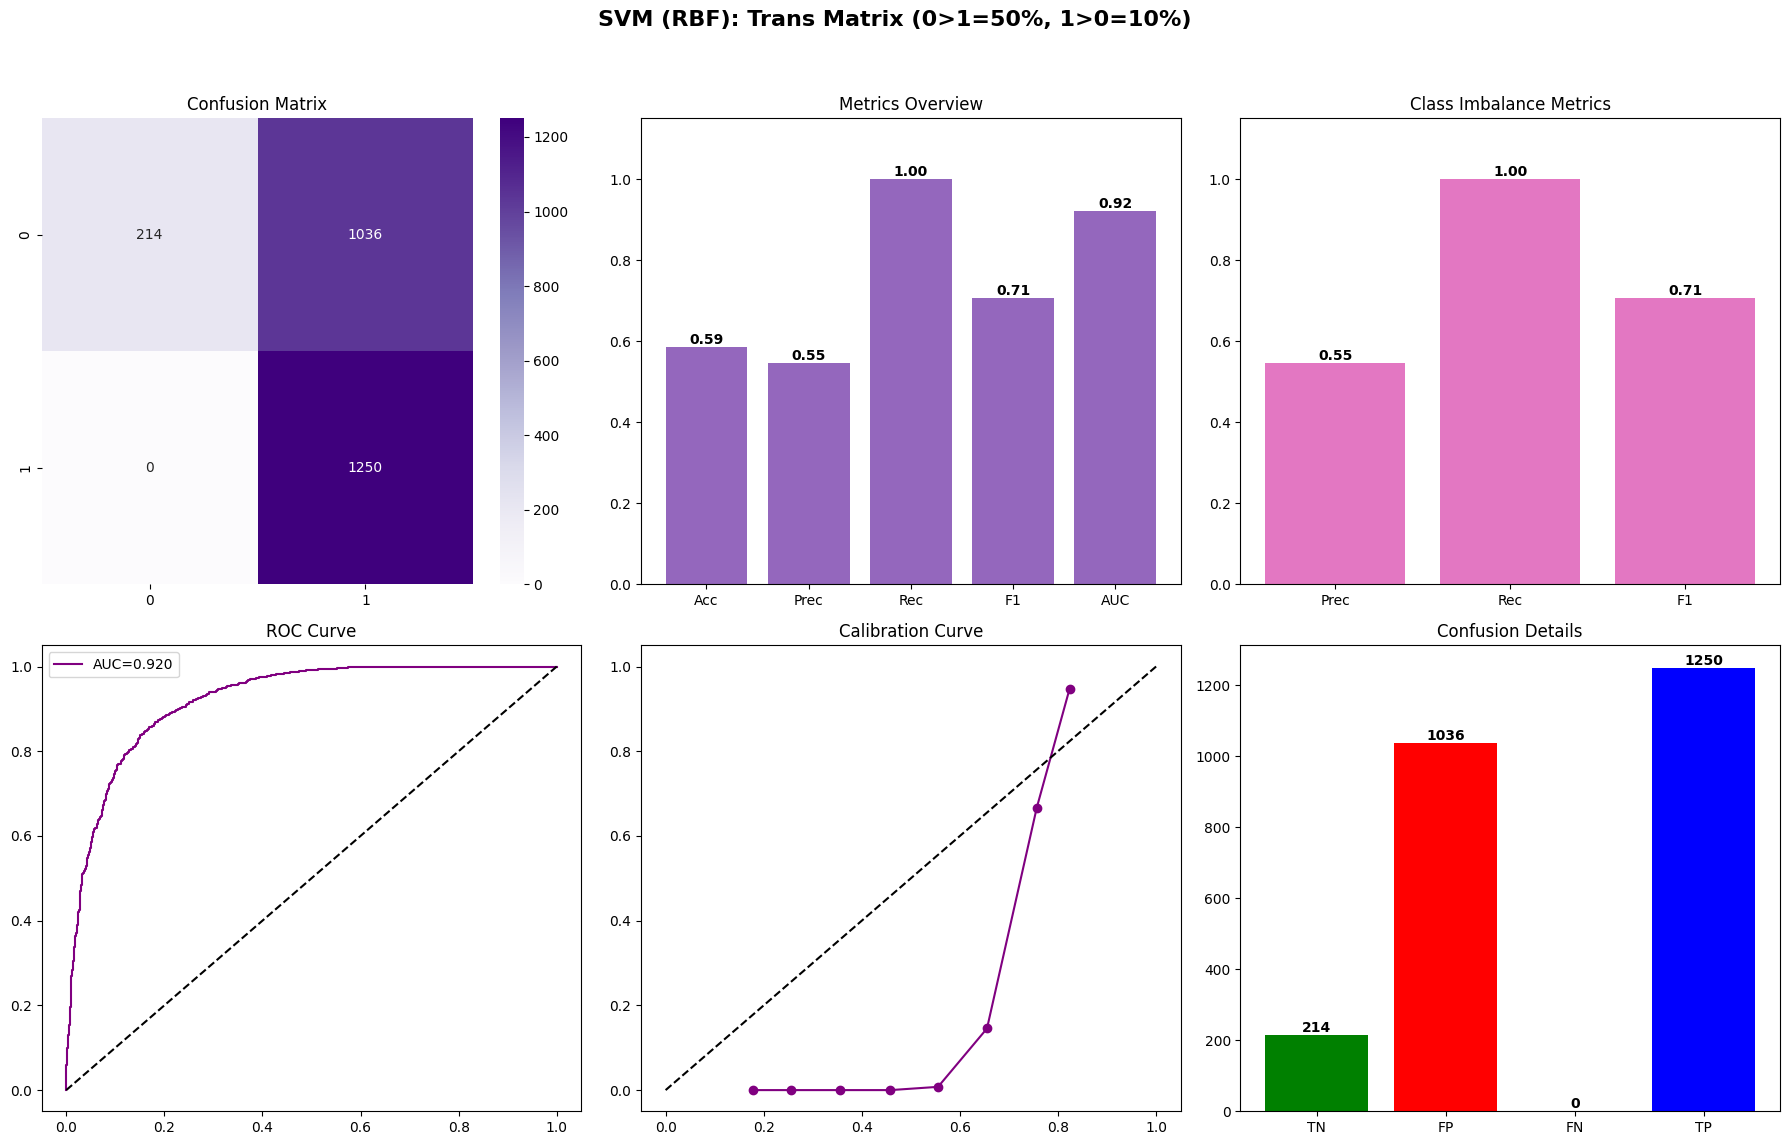

              precision    recall  f1-score   support

           0       1.00      0.17      0.29      1250
           1       0.55      1.00      0.71      1250

    accuracy                           0.59      2500
   macro avg       0.77      0.59      0.50      2500
weighted avg       0.77      0.59      0.50      2500


RESULTS: Trans Matrix (0>1=10%, 1>0=50%)
Acc: 0.5832 | AUC: 0.9027 | F1: 0.2863


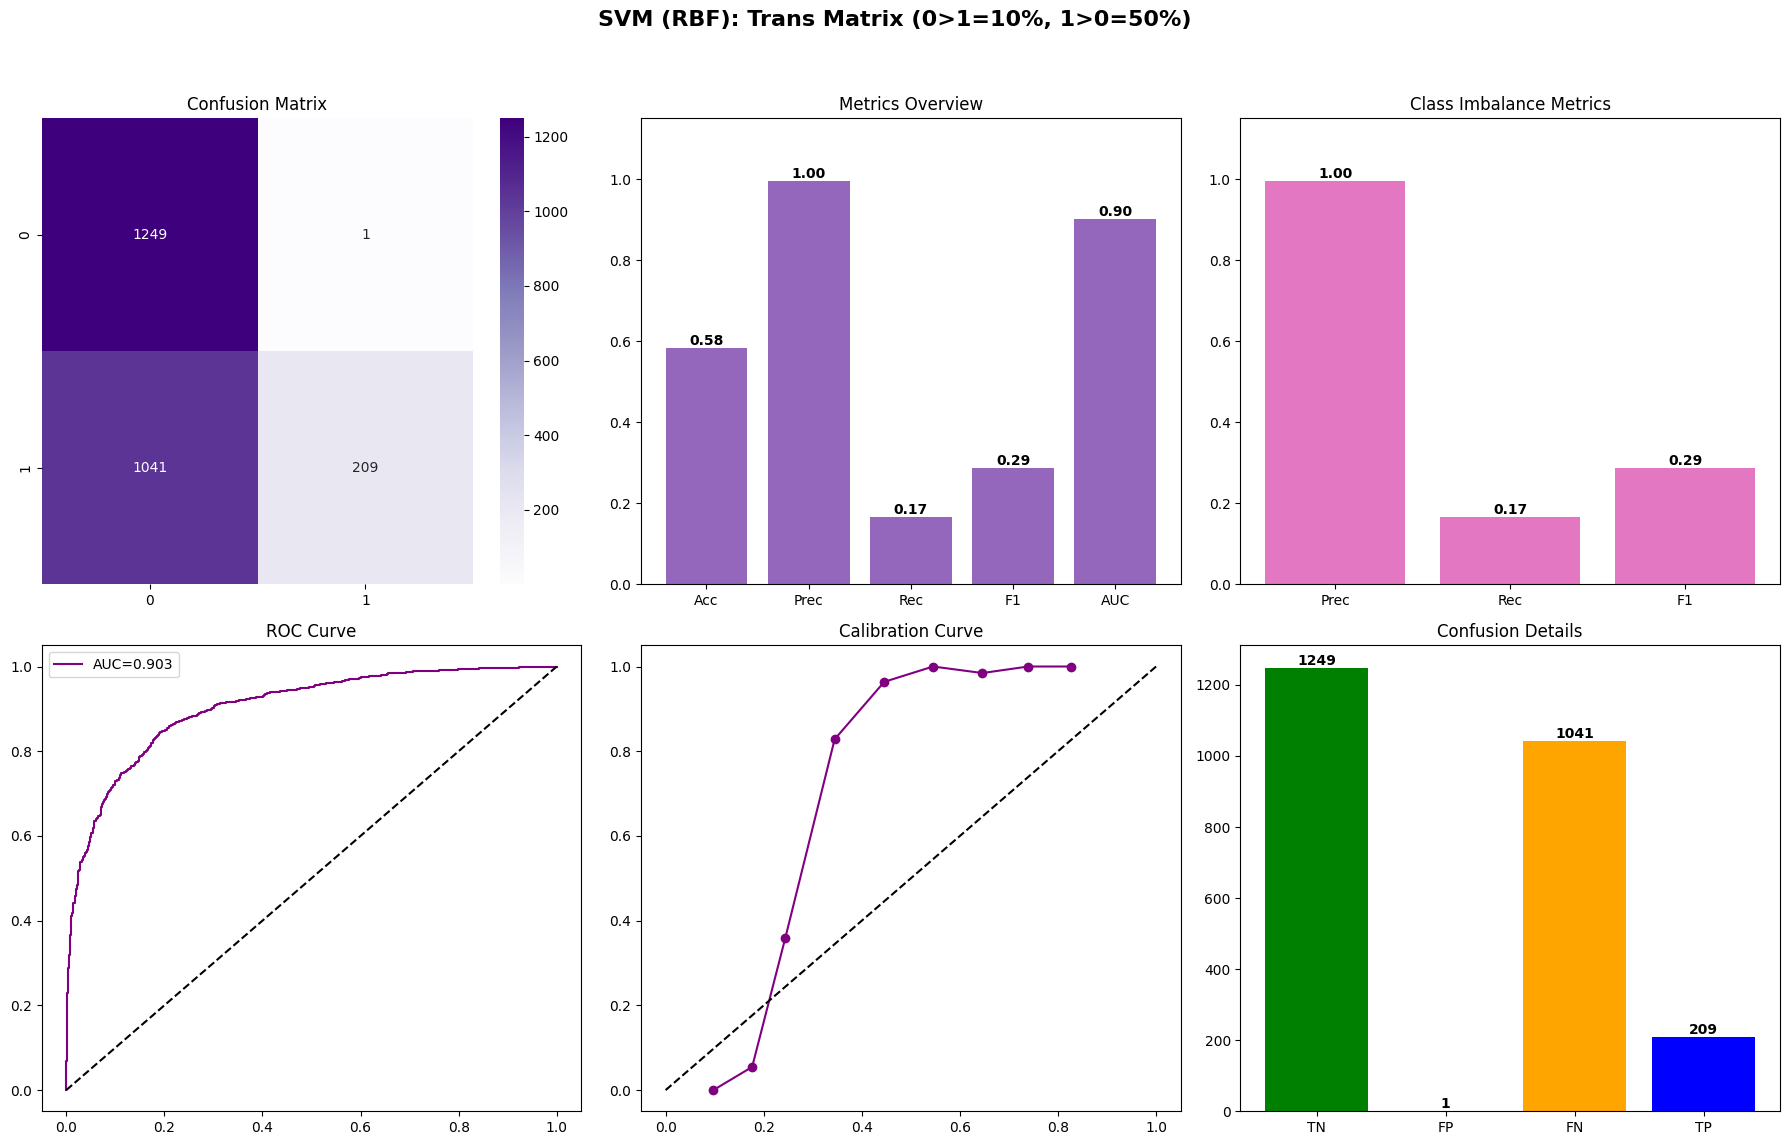

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1250
           1       1.00      0.17      0.29      1250

    accuracy                           0.58      2500
   macro avg       0.77      0.58      0.50      2500
weighted avg       0.77      0.58      0.50      2500



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score, f1_score, roc_curve, roc_auc_score,
                             classification_report)
from sklearn.calibration import calibration_curve

# Data Preprocessing
identifier_cols = [col for col in data.columns if data[col].nunique() == len(data)]
data = data.drop(columns=identifier_cols)

if 'term' in data.columns:
    data['term'] = data['term'].astype(str).str.replace(' months', '').str.strip().astype(float)

if 'emp_length' in data.columns:
    data['emp_length'] = data['emp_length'].astype(str).str.extract(r'(\d+)').astype(float)

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
corr_matrix = data[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]
data = data.drop(columns=to_drop_corr)

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if "loan_status" in categorical_cols: categorical_cols.remove("loan_status")
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data[categorical_cols] = enc.fit_transform(data[categorical_cols])
if "loan_status" in data.columns: data = data.drop(columns=["loan_status"])

bool_like_cols = []
for col in data.columns:
    unique_vals = set(str(v).lower() for v in data[col].dropna().unique())
    if unique_vals.issubset({"true","false","t","f","yes","no","y","n"}):
        bool_like_cols.append(col)

for col in bool_like_cols:
    data[col] = data[col].astype(str).str.lower().map({
        "true":1,"t":1,"yes":1,"y":1, "false":0,"f":0,"no":0,"n":0
    }).astype(int)

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
if "default_binary" in numeric_cols: numeric_cols.remove("default_binary")
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

X = data.drop(columns=["default_binary"])
y = data["default_binary"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Robust Noise Functions (NumPy Conversion)
def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy()
    n_samples = len(y_noisy)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy()
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy()
    n_samples = len(y_noisy)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy()

    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)

    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)

    y_noisy[flip0] = 1
    y_noisy[flip1] = 0
    return y_noisy

# Helper Function
def add_bar_labels(bars, ax, is_int=False):
    for bar in bars:
        height = bar.get_height()
        label = f'{int(height)}' if is_int else f'{height:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plotting Function
def evaluate_and_plot(model, X_test, y_test, title_suffix):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nRESULTS: {title_suffix}")
    print(f"Acc: {acc:.4f} | AUC: {auc:.4f} | F1: {f1:.4f}")

    fig = plt.figure(figsize=(18, 12))
    plt.suptitle(f'SVM (RBF): {title_suffix}', fontsize=16, fontweight='bold')

    ax1 = plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=ax1)
    ax1.set_title('Confusion Matrix')

    ax2 = plt.subplot(2, 3, 2)
    metrics = [acc, prec, rec, f1, auc]
    bars2 = ax2.bar(['Acc', 'Prec', 'Rec', 'F1', 'AUC'], metrics, color='#9467bd')
    ax2.set_ylim(0, 1.15)
    add_bar_labels(bars2, ax2)
    ax2.set_title('Metrics Overview')

    ax3 = plt.subplot(2, 3, 3)
    bars3 = ax3.bar(['Prec', 'Rec', 'F1'], [prec, rec, f1], color='#e377c2')
    ax3.set_ylim(0, 1.15)
    add_bar_labels(bars3, ax3)
    ax3.set_title('Class Imbalance Metrics')

    ax4 = plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax4.plot(fpr, tpr, label=f'AUC={auc:.3f}', color='purple')
    ax4.plot([0, 1], [0, 1], 'k--')
    ax4.legend()
    ax4.set_title('ROC Curve')

    ax5 = plt.subplot(2, 3, 5)
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    ax5.plot(prob_pred, prob_true, marker='o', color='purple')
    ax5.plot([0, 1], [0, 1], 'k--')
    ax5.set_title('Calibration Curve')

    ax6 = plt.subplot(2, 3, 6)
    tn, fp, fn, tp = cm.ravel()
    bars6 = ax6.bar(['TN', 'FP', 'FN', 'TP'], [tn, fp, fn, tp], color=['g', 'r', 'orange', 'b'])
    add_bar_labels(bars6, ax6, is_int=True)
    ax6.set_title('Confusion Details')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print(classification_report(y_test, y_pred))

# Baseline Execution
svc_baseline = SVC(probability=True, kernel='rbf', random_state=42)
svc_baseline.fit(X_train, y_train)
evaluate_and_plot(svc_baseline, X_test, y_test, "Baseline (No Noise)")

# Symmetric Noise Execution
symmetric_rates = [0.10, 0.20, 0.33, 0.50]
for p in symmetric_rates:
    y_train_noisy = inject_symmetric_noise(y_train, noise_rate=p)
    svc_sym = SVC(probability=True, kernel='rbf', random_state=42)
    svc_sym.fit(X_train, y_train_noisy)
    evaluate_and_plot(svc_sym, X_test, y_test, f"Symmetric Noise {int(p*100)}%")

# Asymmetric Noise Execution (0 -> 1)
asymmetric_rates = [0.10, 0.20, 0.33, 0.50]
for p in asymmetric_rates:
    y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=0, flip_fraction=p)
    svc_asym = SVC(probability=True, kernel='rbf', random_state=42)
    svc_asym.fit(X_train, y_train_noisy)
    evaluate_and_plot(svc_asym, X_test, y_test, f"Asymmetric (0->1) Noise {int(p*100)}%")

# Asymmetric Noise Execution (1 -> 0)
for p in asymmetric_rates:
    y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=1, flip_fraction=p)
    svc_asym = SVC(probability=True, kernel='rbf', random_state=42)
    svc_asym.fit(X_train, y_train_noisy)
    evaluate_and_plot(svc_asym, X_test, y_test, f"Asymmetric (1->0) Noise {int(p*100)}%")

# Random Flip Execution
flip_rates = [0.10, 0.20, 0.33, 0.50]
for p in flip_rates:
    y_train_noisy = inject_random_label_flip(y_train, flip_rate=p)
    svc_flip = SVC(probability=True, kernel='rbf', random_state=42)
    svc_flip.fit(X_train, y_train_noisy)
    evaluate_and_plot(svc_flip, X_test, y_test, f"Random Flip Noise {int(p*100)}%")

# Confusion Matrix Execution
confusion_params = [
    (0.20, 0.05),
    (0.05, 0.20),
    (0.50, 0.10),
    (0.10, 0.50)
]
for eta01, eta10 in confusion_params:
    y_train_noisy = apply_confusion_matrix_noise(y_train, eta_01=eta01, eta_10=eta10)
    svc_cm = SVC(probability=True, kernel='rbf', random_state=42)
    svc_cm.fit(X_train, y_train_noisy)
    evaluate_and_plot(svc_cm, X_test, y_test, f"Trans Matrix (0>1={int(eta01*100)}%, 1>0={int(eta10*100)}%)")